# **Домашнее задание 4 (base): древесные алгоритмы**

### **Постановка задачи:**

У вас есть данные о полетах, обладающие следущими характеристиками:
- Для **каждого** клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.
- Для **некоторых** клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied).

По данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, **для которых ответ неизвестен.**

### **Получение данных:**

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 0.7 бонусных баллов.

Оценка за ДЗ = min{ваш балл, 10}

Мягкий дедлайн: 25 января 23:59

**Продуктивной и интересной вам работы!**

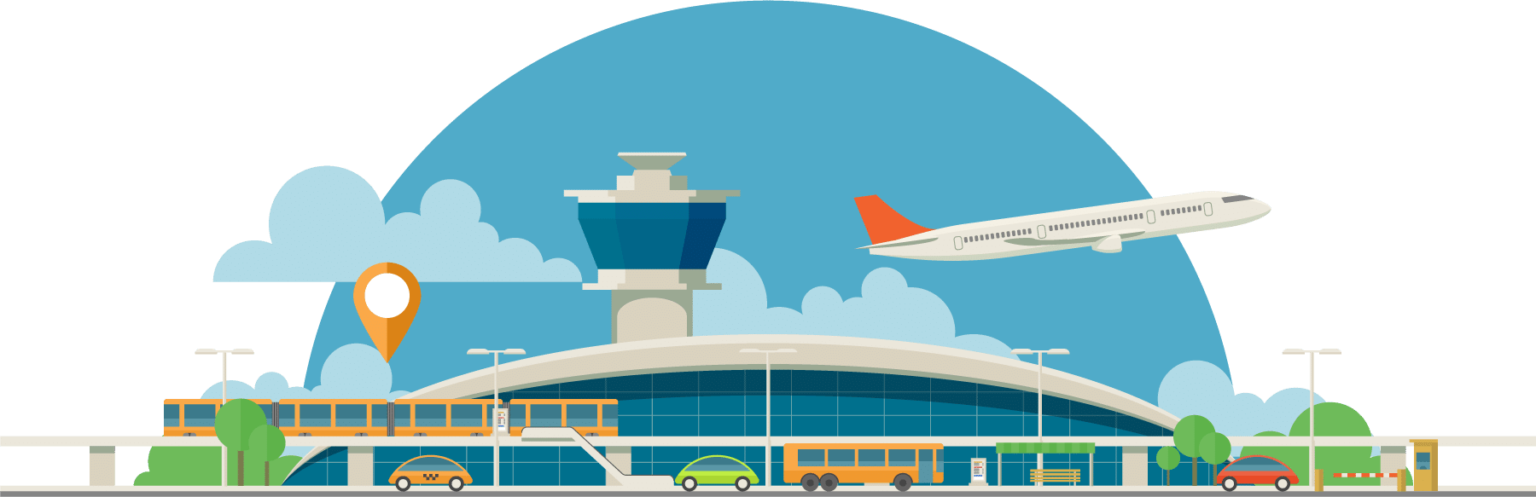

In [1]:
# установка всех библиотек, необходимых для выполнения ДЗ

!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

import missingno as msno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)

# **Часть 1: Получение данных, обработка и EDA (2.75 балла)**

В этой части вам необходимо:
- Загрузить данные из БД и предобработать их (1.75 бала)
- Провести разведочный анализ данных (1. балл)

## **1. 1. Загрузка и предобработка данных (1.75 балла)**

In [3]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2025-01-25 20:39:29--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2025-01-25 20:39:31 (1.16 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



### **Задание 1. Получение данных (0.5 балла)**

- Подключитесь к БД при помощи `psycopg2.connect()`
- Напишите SQL-запрос, объединяющий 3 нужные таблицы в одну
- Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'.

Список столбцов таблиц добудьте самостоятельно.


**Примечание:**
 Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

##### **Параметры соединения:**
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write```
```

##### **Схема БД**

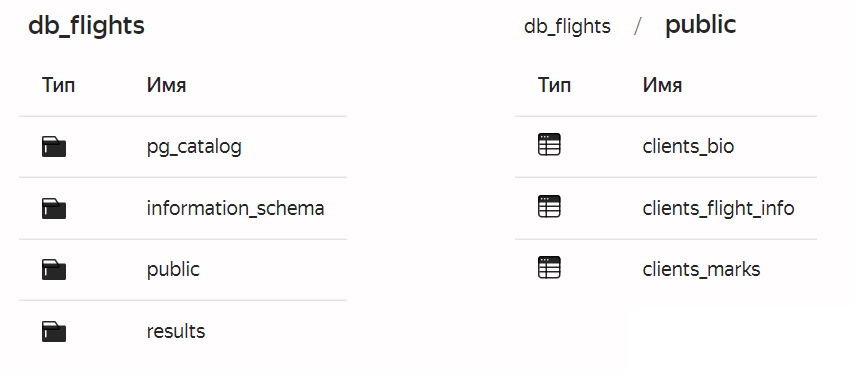



In [4]:
conn_params = {
    "host": "rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net",
    "port": 6432,
    "dbname": "db_flights",
    "user": "mlhs_student",
    "password": "mlhs_student",
    "sslmode": "verify-full",
    "target_session_attrs": "read-write",
}

with psycopg2.connect(**conn_params) as conn:
    with conn.cursor() as cursor:
        cursor.execute("""
            SELECT table_name, column_name
            FROM information_schema.columns
            WHERE table_schema = 'public' AND table_name IN ('clients_bio', 'clients_flight_info', 'clients_marks');
        """)
        table_structure = cursor.fetchall()
        for table, column in table_structure:
            print(f"Таблица: {table}, Столбец: {column}")

Таблица: clients_bio, Столбец: id
Таблица: clients_bio, Столбец: gender
Таблица: clients_bio, Столбец: age
Таблица: clients_flight_info, Столбец: id
Таблица: clients_flight_info, Столбец: Customer Type
Таблица: clients_flight_info, Столбец: Type of Travel
Таблица: clients_flight_info, Столбец: class
Таблица: clients_flight_info, Столбец: Flight Distance
Таблица: clients_flight_info, Столбец: Departure Delay in Minutes
Таблица: clients_flight_info, Столбец: Arrival Delay in Minutes
Таблица: clients_marks, Столбец: id
Таблица: clients_marks, Столбец: Inflight wifi service
Таблица: clients_marks, Столбец: Departure/Arrival time convenient
Таблица: clients_marks, Столбец: Ease of Online booking
Таблица: clients_marks, Столбец: Gate location
Таблица: clients_marks, Столбец: Food and drink
Таблица: clients_marks, Столбец: Online boarding
Таблица: clients_marks, Столбец: Seat comfort
Таблица: clients_marks, Столбец: Inflight entertainment
Таблица: clients_marks, Столбец: On-board service
Табл

In [5]:
query = """
    SELECT
        cb.id,
        cb.gender,
        cb.age,
        cfi."Customer Type",
        cfi."Type of Travel",
        cfi.class,
        cfi."Flight Distance",
        cfi."Departure Delay in Minutes",
        cfi."Arrival Delay in Minutes",
        cm."Inflight wifi service",
        cm."Departure/Arrival time convenient",
        cm."Ease of Online booking",
        cm."Gate location",
        cm."Food and drink",
        cm."Online boarding",
        cm."Seat comfort",
        cm."Inflight entertainment",
        cm."On-board service",
        cm."Leg room service",
        cm."Baggage handling",
        cm."Checkin service",
        cm."Inflight service",
        cm.cleanliness,
        cm.satisfaction
    FROM public.clients_bio AS cb
    JOIN public.clients_flight_info AS cfi ON cb.id = cfi.id
    JOIN public.clients_marks AS cm ON cb.id = cm.id;
"""

with psycopg2.connect(**conn_params) as conn:
    df = pd.read_sql_query(query, conn)

df.set_index('id', inplace=True)

In [6]:
df.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
7           1963.0                        0.0                      0.0   
13           453.0                       16.0                     30.0   
18           821.0                        0.0                      0.0   
31           212.0                        0.0                      0.0   
39            67.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  ...  \
id                                                          ...   
7                    3.0                               3.0  ...   
13                   2.0                               2.0  ...   
18                   2.0                               5.0  ...   
31                   2.0                               2.0  ...   
39                   3.0                               3.0  ...   

   Online boarding Seat comfort Inflight entertainment On-board service  \
id                                                                        
7              4.0          5.0                    5.0              5.0   
13             2.0          5.0                    5.0              2.0   
18             1.0          5.0                    5.0              5.0   
31             2.0          2.0                    2.0              4.0   
39             5.0          4.0                    4.0              4.0   

   Leg room service Baggage handling Checkin service Inflight service  \
id                                                                      
7               5.0              5.0             4.0              5.0   
13              4.0              4.0             2.0              4.0   
18              2.0              5.0             5.0              5.0   
31              5.0              5.0             5.0              4.0   
39              4.0              4.0             5.0              4.0   

   cleanliness             satisfaction  
id                                       
7          4.0                satisfied  
13         5.0  neutral or dissatisfied  
18         1.0  neutral or dissatisfied  
31         2.0  neutral or dissatisfied  
39         5.0                satisfied  

[5 rows x 23 columns]

In [7]:
assert df.shape == (129_549, 23)

### **Задание 2 (0.25 балла)**

- Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [8]:
col_not_change_type = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction'] # список столбцов, которые не надо преобразовывать

for col in df.columns:
  if col not in col_not_change_type:
    df[col] = df[col].astype(float)

In [9]:
# количетво пропусков в столбцах
df.isna().sum()

gender                                 0
age                                  315
Customer Type                          0
Type of Travel                         0
class                                  0
Flight Distance                       94
Departure Delay in Minutes           107
Arrival Delay in Minutes             507
Inflight wifi service                 44
Departure/Arrival time convenient     49
Ease of Online booking                43
Gate location                         37
Food and drink                        50
Online boarding                       46
Seat comfort                          47
Inflight entertainment                45
On-board service                      44
Leg room service                      46
Baggage handling                      48
Checkin service                       42
Inflight service                      63
cleanliness                           37
satisfaction                           0
dtype: int64

```
Практически во всех столбцах есть пропуски, но не в большом количестве.
```

In [10]:
# Выбросы в числовых столбцах
def find_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] < lower_bound) | (data[column] > upper_bound)]

numeric_cols = df.select_dtypes(include=['float64']).columns
for col in numeric_cols:
    outliers = find_outliers_iqr(df, col)
    print(f"Столбец {col}: {len(outliers)} выбросов")

Столбец age: 448 выбросов
Столбец Flight Distance: 3074 выбросов
Столбец Departure Delay in Minutes: 18124 выбросов
Столбец Arrival Delay in Minutes: 17499 выбросов
Столбец Inflight wifi service: 24 выбросов
Столбец Departure/Arrival time convenient: 35 выбросов
Столбец Ease of Online booking: 29 выбросов
Столбец Gate location: 39 выбросов
Столбец Food and drink: 28 выбросов
Столбец Online boarding: 32 выбросов
Столбец Seat comfort: 34 выбросов
Столбец Inflight entertainment: 23 выбросов
Столбец On-board service: 26 выбросов
Столбец Leg room service: 39 выбросов
Столбец Baggage handling: 27 выбросов
Столбец Checkin service: 16103 выбросов
Столбец Inflight service: 39 выбросов
Столбец cleanliness: 25 выбросов


In [11]:
# Выбросы в категориальных столбцах (редкие категории)
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
  print(df[col].value_counts())
  print()

gender
Female    65726
Male      63823
Name: count, dtype: int64

Customer Type
Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: count, dtype: int64

Type of Travel
Business travel    89405
Personal Travel    40043
nan                  101
Name: count, dtype: int64

class
Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: count, dtype: int64

satisfaction
neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: count, dtype: int64



```
В числовым столбцах есть выбросы, удалять их не стоит, т.к. при обучении модели они могут быть полезны.  
В категориальных столбцах выбросами можно считать пропущенные значения - nan или значение "-" в столбце satisfaction.
```

### **Задание 3 (0.5 балла)**

Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме. Постройте:
-  `matrix` пропущенных значений;
- столбчатую диаграмму в **логарифмированной** шкале (так как пропусков немного, по обычной не будет видно, в каких столбцах их больше)

<Axes: >

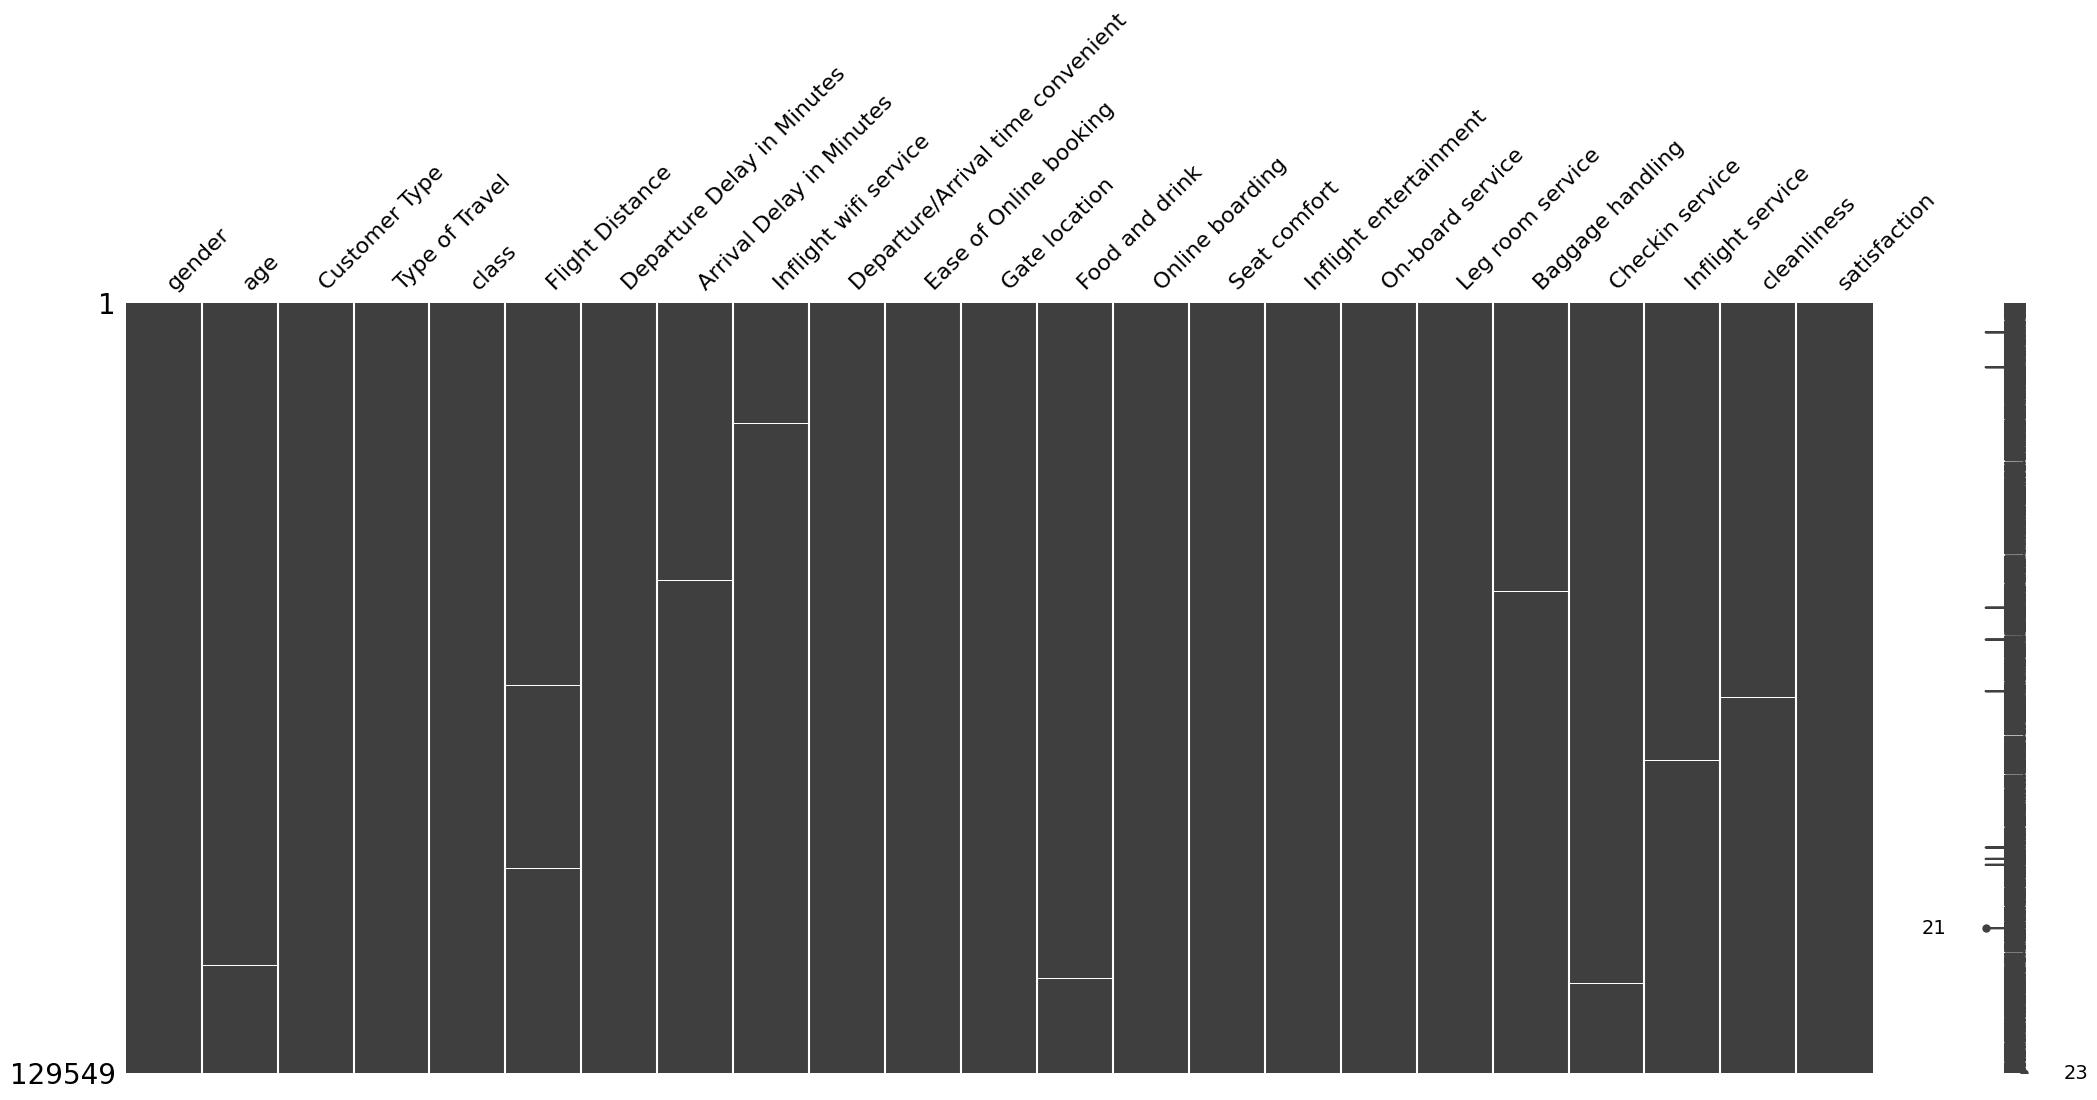

In [12]:
msno.matrix(df)

<Axes: >

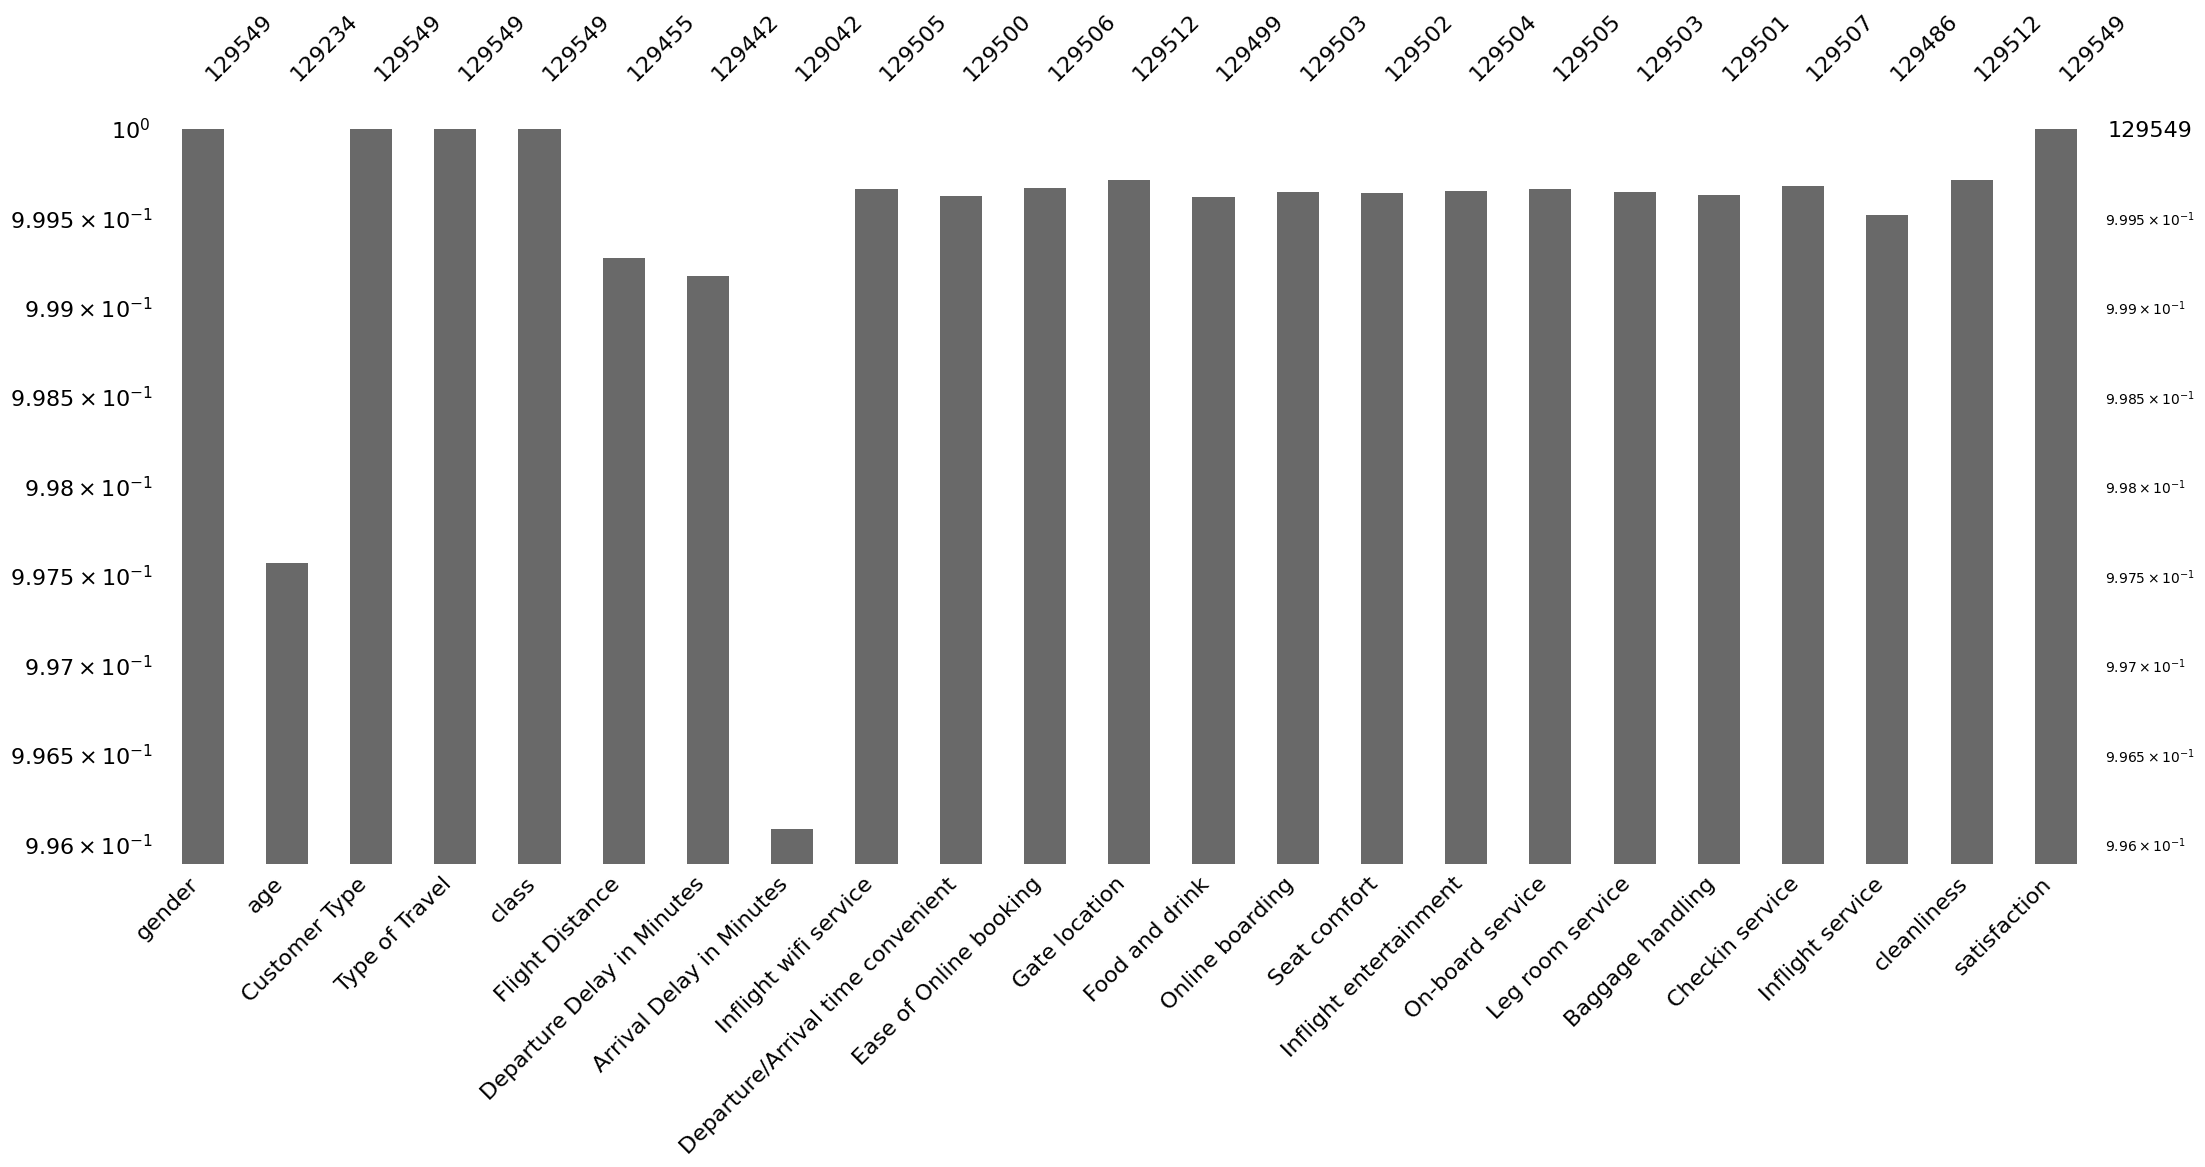

In [13]:
msno.bar(df, log=True)

```
Видно, что больше всего пропусков в столбцах age и Arrival Delay in Minutes.
```

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука.

In [14]:
df_train = df[df.satisfaction != '-']
df_train.head()

gender   age      Customer Type   Type of Travel     class  \
id                                                               
7     Male  43.0     Loyal Customer  Business travel  Business   
13    Male  24.0  disloyal Customer  Business travel       Eco   
18  Female  61.0     Loyal Customer  Personal Travel       Eco   
31    Male  35.0  disloyal Customer  Business travel  Business   
39  Female  46.0     Loyal Customer  Business travel  Business   

    Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                          
7            1963.0                         0.0                       0.0   
13            453.0                        16.0                      30.0   
18            821.0                         0.0                       0.0   
31            212.0                         0.0                       0.0   
39             67.0                         0.0                       0.0   

    Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                            ...   
7                     3.0                                3.0  ...   
13                    2.0                                2.0  ...   
18                    2.0                                5.0  ...   
31                    2.0                                2.0  ...   
39                    3.0                                3.0  ...   

    Online boarding  Seat comfort  Inflight entertainment  On-board service  \
id                                                                            
7               4.0           5.0                     5.0               5.0   
13              2.0           5.0                     5.0               2.0   
18              1.0           5.0                     5.0               5.0   
31              2.0           2.0                     2.0               4.0   
39              5.0           4.0                     4.0               4.0   

    Leg room service  Baggage handling  Checkin service  Inflight service  \
id                                                                          
7                5.0               5.0              4.0               5.0   
13               4.0               4.0              2.0               4.0   
18               2.0               5.0              5.0               5.0   
31               5.0               5.0              5.0               4.0   
39               4.0               4.0              5.0               4.0   

    cleanliness             satisfaction  
id                                        
7           4.0                satisfied  
13          5.0  neutral or dissatisfied  
18          1.0  neutral or dissatisfied  
31          2.0  neutral or dissatisfied  
39          5.0                satisfied  

[5 rows x 23 columns]

In [15]:
assert df_train.shape == (103_644, 23)

In [16]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test.head()

gender   age   Customer Type   Type of Travel     class  Flight Distance  \
id                                                                              
55     Male  36.0  Loyal Customer  Business travel  Business           3655.0   
79   Female  70.0  Loyal Customer  Personal Travel       Eco            108.0   
126    Male  66.0  Loyal Customer  Personal Travel       Eco            562.0   
199  Female  60.0  Loyal Customer  Business travel  Business           3756.0   
263    Male  43.0  Loyal Customer  Personal Travel  Business            802.0   

     Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                          
55                         40.0                      71.0   
79                         50.0                      41.0   
126                        88.0                      84.0   
199                        36.0                      24.0   
263                         0.0                       0.0   

     Inflight wifi service  Departure/Arrival time convenient  ...  \
id                                                             ...   
55                     1.0                                1.0  ...   
79                     5.0                                4.0  ...   
126                    2.0                                5.0  ...   
199                    4.0                                4.0  ...   
263                    1.0                                2.0  ...   

     Food and drink  Online boarding  Seat comfort  Inflight entertainment  \
id                                                                           
55              1.0              3.0           3.0                     3.0   
79              4.0              4.0           4.0                     3.0   
126             5.0              2.0           5.0                     5.0   
199             2.0              4.0           5.0                     4.0   
263             2.0              3.0           3.0                     2.0   

     On-board service  Leg room service  Baggage handling  Checkin service  \
id                                                                           
55                3.0               3.0               1.0              4.0   
79                3.0               0.0               3.0              5.0   
126               3.0               5.0               2.0              5.0   
199               4.0               4.0               4.0              5.0   
263               2.0               1.0               2.0              3.0   

     Inflight service  cleanliness  
id                                  
55                3.0          2.0  
79                3.0          5.0  
126               5.0          5.0  
199               4.0          5.0  
263               2.0          1.0  

[5 rows x 22 columns]

In [17]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [18]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [19]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

### **Задание 4. (0.15 балла)**

Заполните пропуски в данных наиболее часто встречающимся значением.
Помните про правильность заполнения.

**Примечание:** Мы также могли восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Как правило, такое заполнение точнее и лучше сохраняет структуру распределений. Но для признаков в нашей задаче Imputer'ы, реализованные библиотечно не подошли бы. Они возвращали бы вещественные значения, а в нашей задаче все признаки целые.

In [20]:
columns_with_nulls = df.columns[df.isnull().any()]

for col in columns_with_nulls:
  most_frequent_value = df_test[col].value_counts().index[0]
  df_test[col].fillna(most_frequent_value, inplace=True)

  most_frequent_train_value = X_train[col].value_counts().index[0]
  X_train[col].fillna(most_frequent_train_value, inplace=True)
  X_val[col].fillna(most_frequent_train_value, inplace=True) # в вал. датасете пропуски заполняем по трейну

### **Задание 5. (0.1 балла)**

- Выведите основные статистики по числовым и категориальным столбцам таблицы
- Сделайте **текстовый** вывод о распределениях значений признаков

In [21]:
df.describe(include='float')

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [22]:
df.describe(include='object')

gender   Customer Type   Type of Travel     class  \
count   129549          129549           129549    129549   
unique       2               3                3         4   
top     Female  Loyal Customer  Business travel  Business   
freq     65726          105763            89405     61939   

                   satisfaction  
count                    129549  
unique                        3  
top     neutral or dissatisfied  
freq                      58732

```
Выводы по числовым столбцам:
- age: ср. значение возраста составляет 40 лет, при этом минимальное - 0, возможно, это дети до года. В данных точно есть ошибки, т.к. максимальный возраст - 621 год, что невозможно;
- Flight Distance: ср. значение дальности полета - 1.322 мили, при этом максимальное - 379.620 ~ 610.939 км.,
это подозрительно много, т.к. мировой рекорд расстояния без подзапрвки - 21.601 км.;
- Departure Delay in Minutes: ср. задержка рейса ~ 16 минут, однако стандартное отклонение превышает
90 минут, это говорит о том, что задержки могут сильно варьироваться. Максимальная задержка - 22.227 минут
(~370 часов), что кажется мало реалистичным и может говорить об ошибке в данных;
- Arrival Delay in Minutes: задержки прибытия имеют схожие характеристики с задержками вылета:
среднее значение около 17 минут, но стандартное отклонение выше 100 минут. Максимальные значения также выглядят подозрительно высокими
(до 14006 минут, что эквивалентно почти 234 часам);  
Остальные столбцы с оценками от пассжиров не имеют каких-то странных значений.

Вывод по категориальным столбцам:
- С данными столбцами тоже все в порядке, кроме категорий, nan, т.е. пропусков и категории
со значениема "-".
```





### **Задание 6 (0.25 балла)**

- Удалите строки c выбросами в числовых столбцах (для трейна и валидации; тест оставьте без изменений).

**Примечание:** Выбросами считайте значения признака, строго превышающие 0.996-квантиль.

По определению, квантиль — значение, которое заданная случайная величина не превышает с фиксированной вероятностью. То есть, если мы смотрим на квантиль 0.996-квантиль, то значения после этого квантиля встречаются в 0.004% случаев. В среднем для всех признаков эти значения начинаются ~в этом квантиле.



In [23]:
def remove_outliers_numeric(X, y):
    numeric_columns = X.select_dtypes(include=['number'])
    quantiles = numeric_columns.quantile(0.996)

    outliers = (numeric_columns > quantiles).any(axis=1)

    X_clean = X[~outliers]
    y_clean = y[~outliers]

    return X_clean, y_clean

X_train, y_train = remove_outliers_numeric(X_train, y_train)
X_val, y_val = remove_outliers_numeric(X_val, y_val)

In [24]:
assert df_test.shape == (25_905, 22)

## **1. 2. EDA (1 балл)**

Создадим переменные с перечислениями столбцов разного типа

In [25]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [26]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

### **Задание 7. (0.3 балла)**

- Напишите процедуры для отрисовки графиков;
 * Для признаков, которые мы выделили как порядковые и для категориальных, отображайте только `countplot`
  * Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)

- Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне. Всё должно красиво работать! :)

**Примечание 1:**

Помните про хороший тон визуализации — все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима! За неё также могут быть сняты баллы.

**Примечание 2:**

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

In [27]:
def plot_ordinal(cols, df, y):
    """
    Draws countplots for all columns in 'cols' with informative title
    """
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue=y, palette='viridis')
        plt.title(f'Распределение значений {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.legend(title='Target')
        plt.show()

In [28]:
def plot_continuous(cols, df, y):
    """
    Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    for col in cols:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        sns.kdeplot(data=df, x=col, hue=y, fill=True, ax=axes[0], palette='viridis')
        axes[0].set_title(f'Распределение {col}')
        axes[0].set_xlabel(col)
        axes[0].set_ylabel('Плотность')

        sns.boxplot(data=df, x=y, y=col, palette='viridis', ax=axes[1])
        axes[1].set_title(f'Ящик с усами для {col}')
        axes[1].set_xlabel('Target')
        axes[1].set_ylabel(col)

        plt.tight_layout()
        plt.show()

In [29]:
def plot_categorical(cols, df, y):
    """
    Draws countplots for all columns in 'cols' with informative title
    """
    for col in cols:
        plt.figure(figsize=(10, 5))
        sns.countplot(data=df, x=col, hue=y, palette='viridis')
        plt.title(f'Распределение значений {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.legend(title='Target')
        plt.show()

Отрисовка.

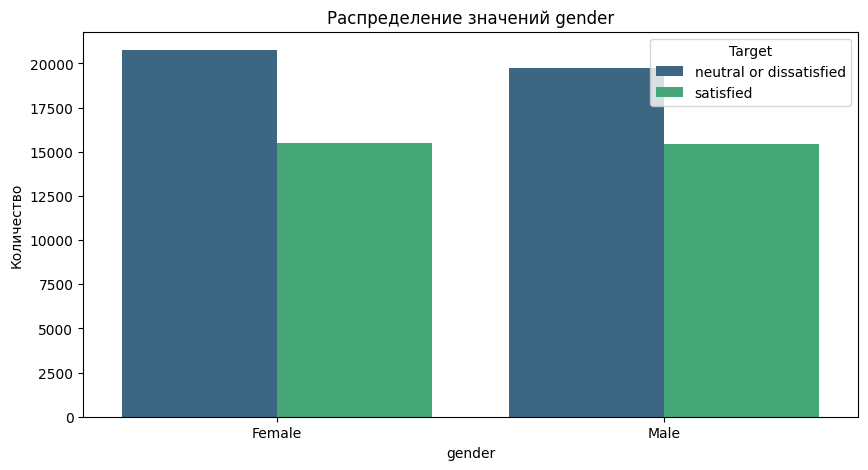

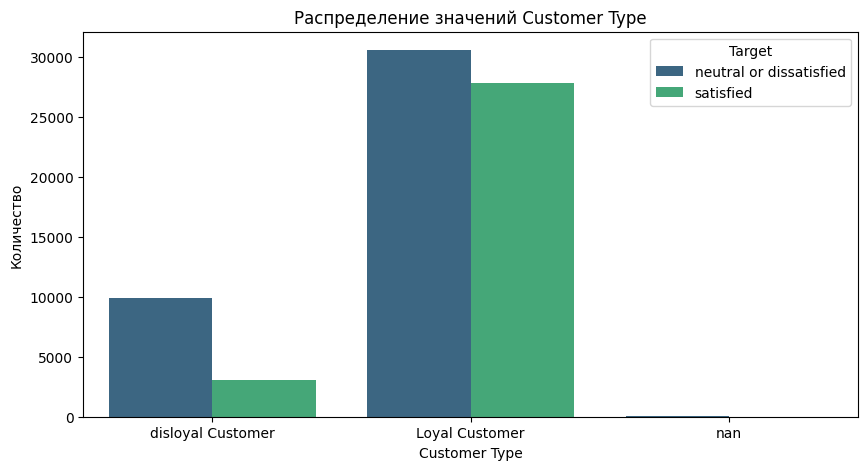

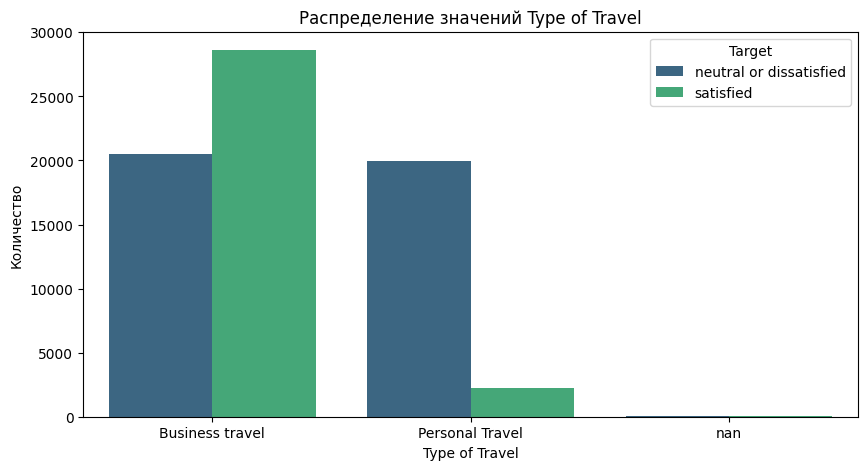

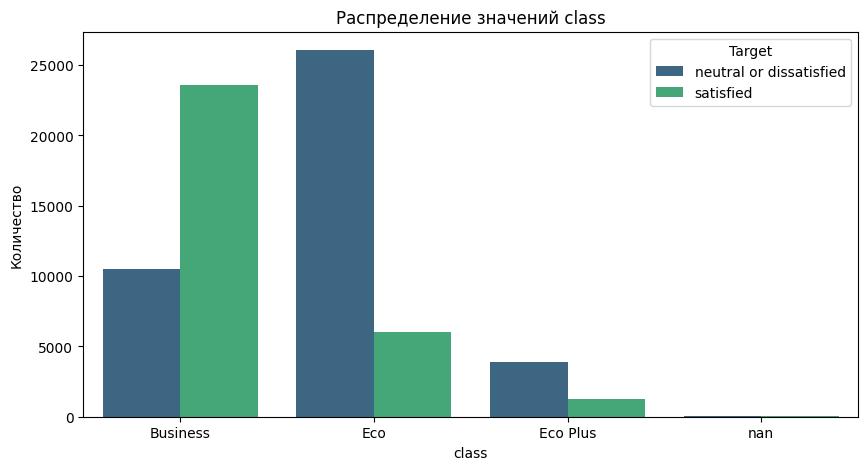

In [30]:
plot_categorical(categorical_cols, X_train, y_train)

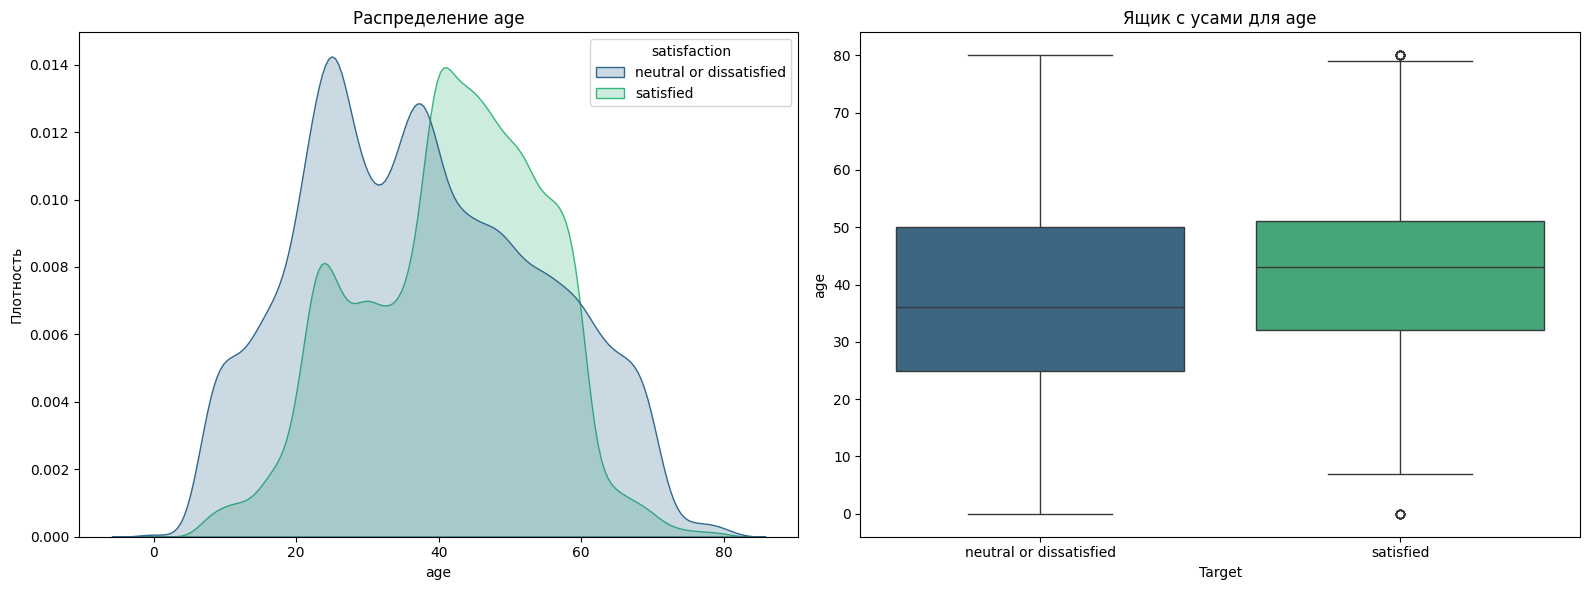

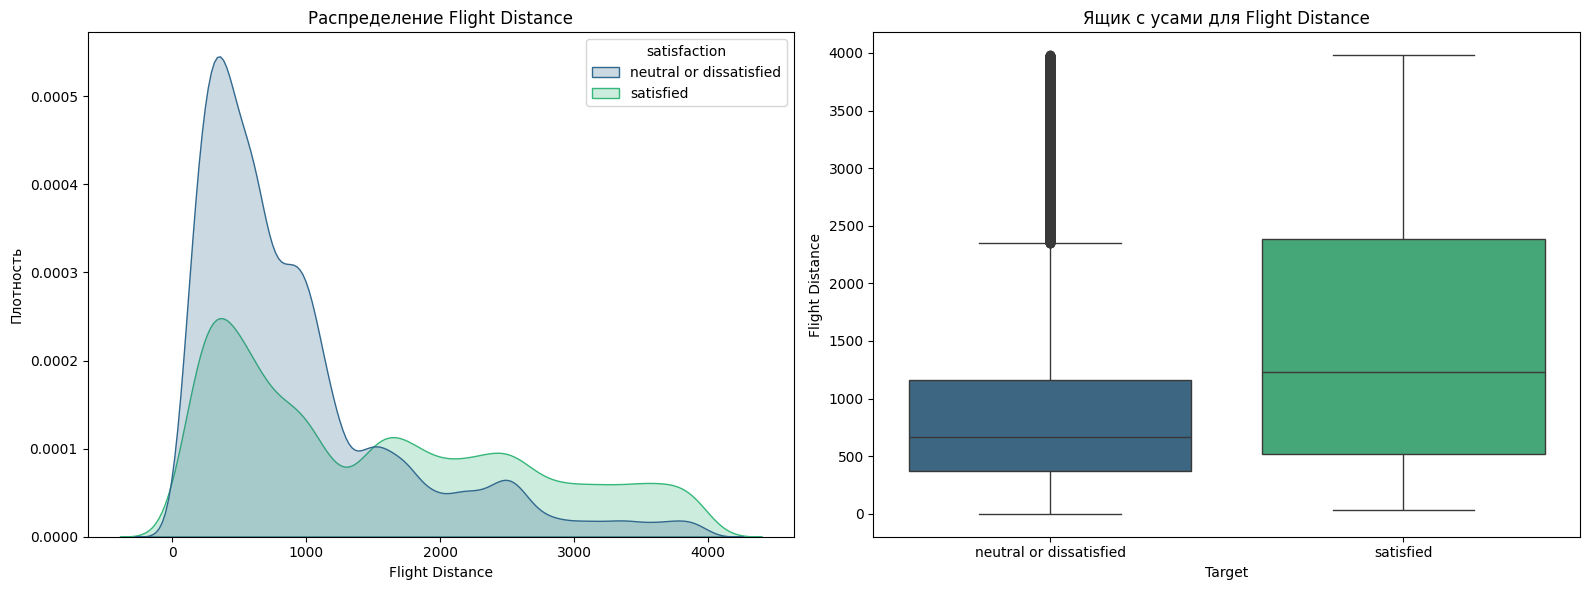

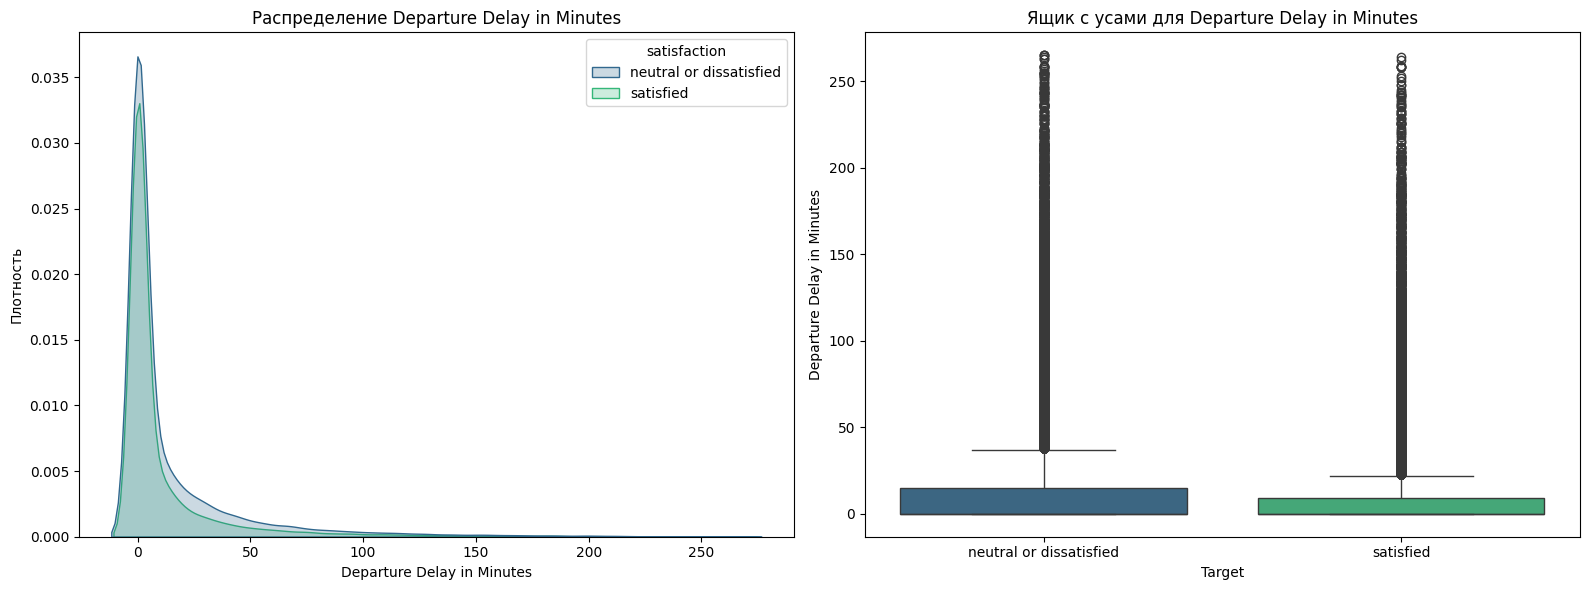

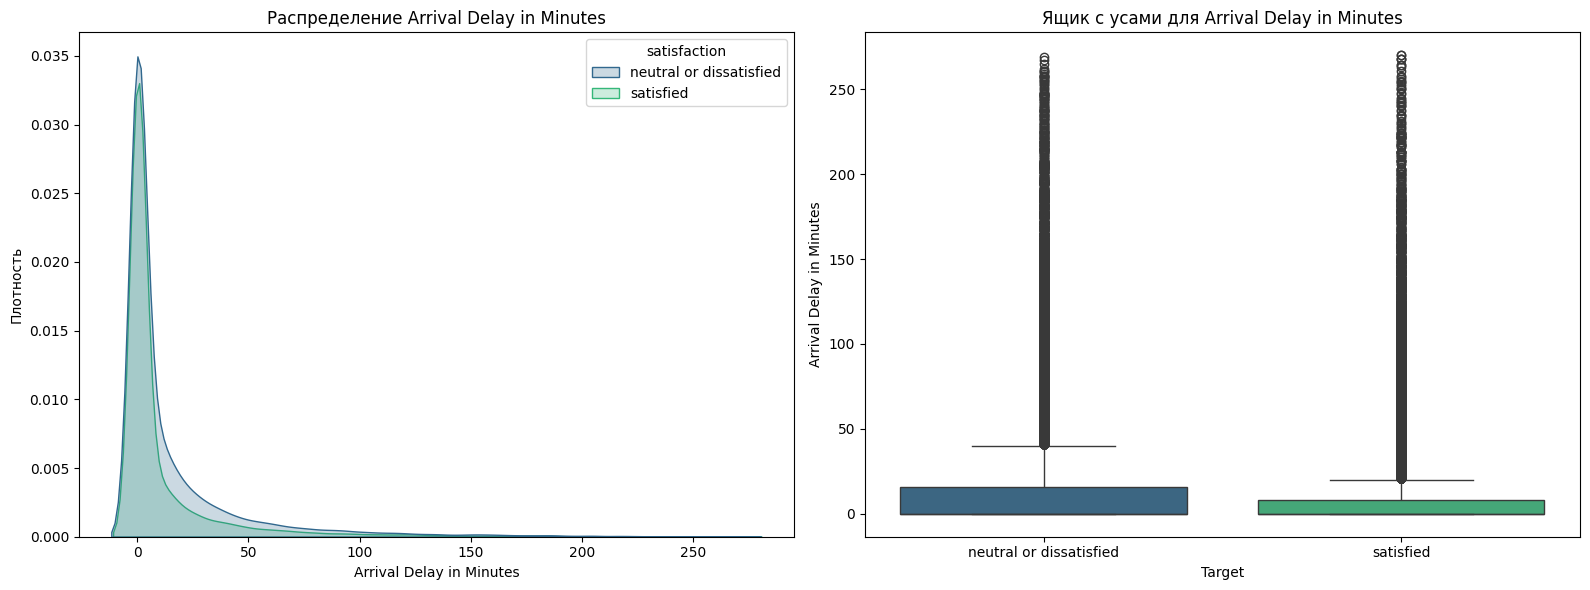

In [31]:
plot_continuous(continuous_cols, X_train, y_train)

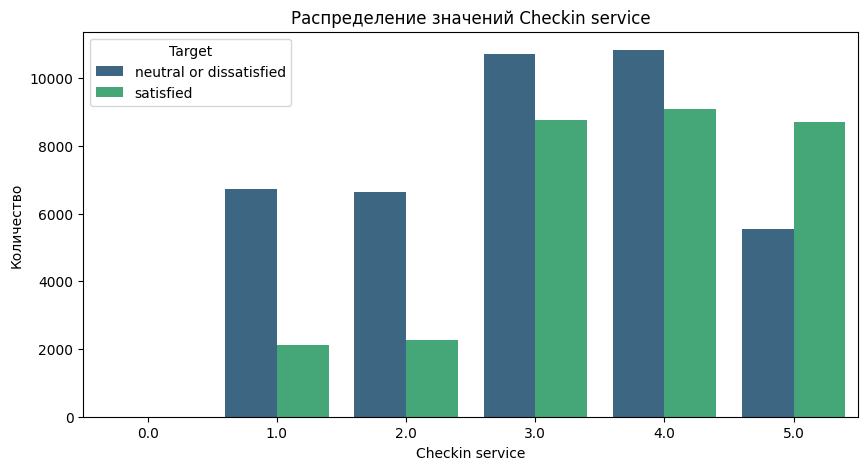

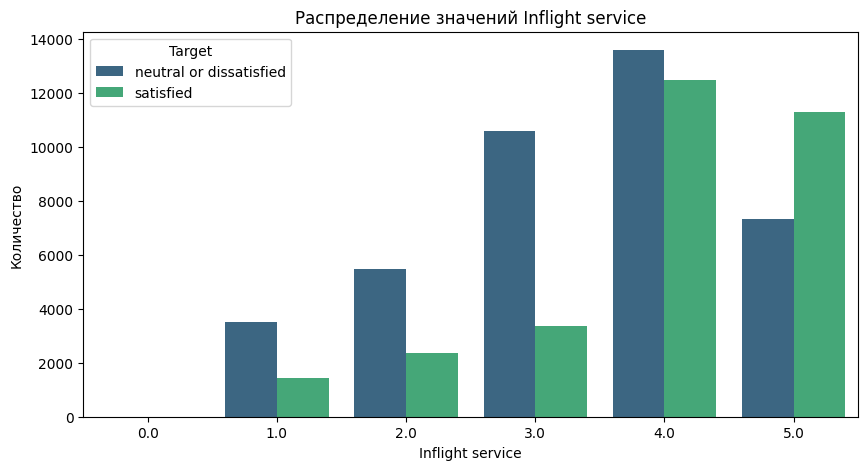

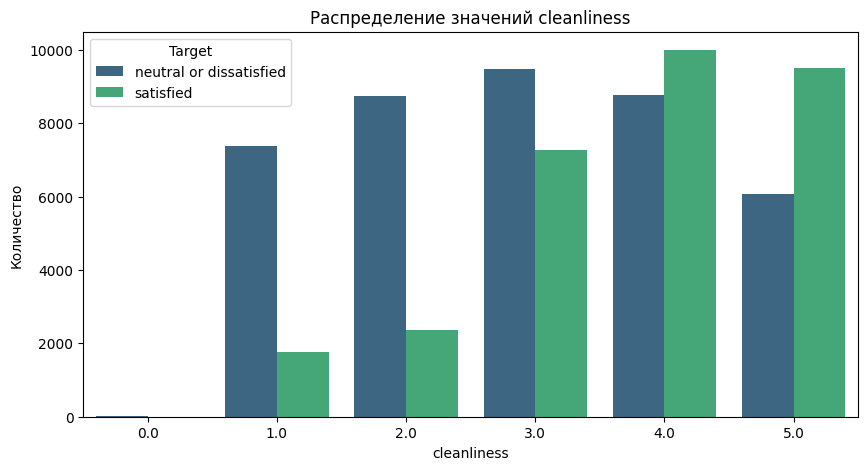

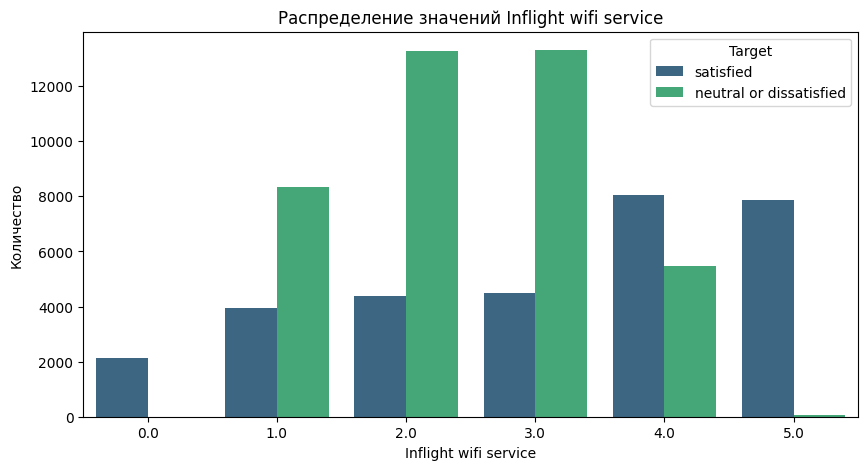

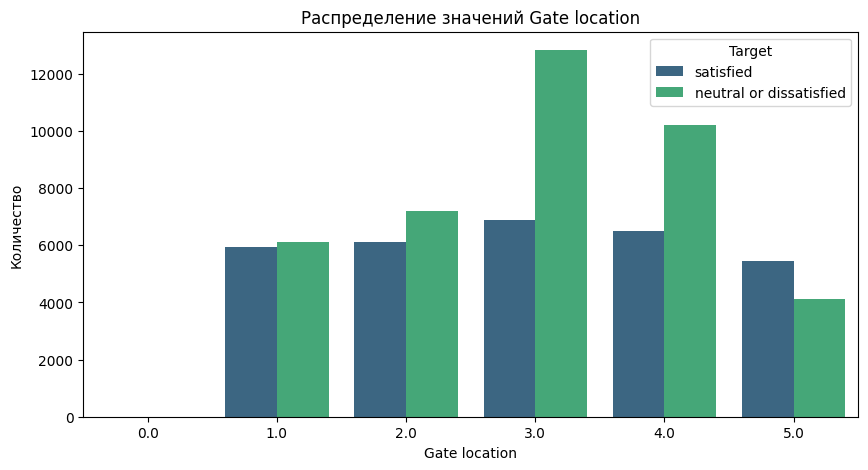

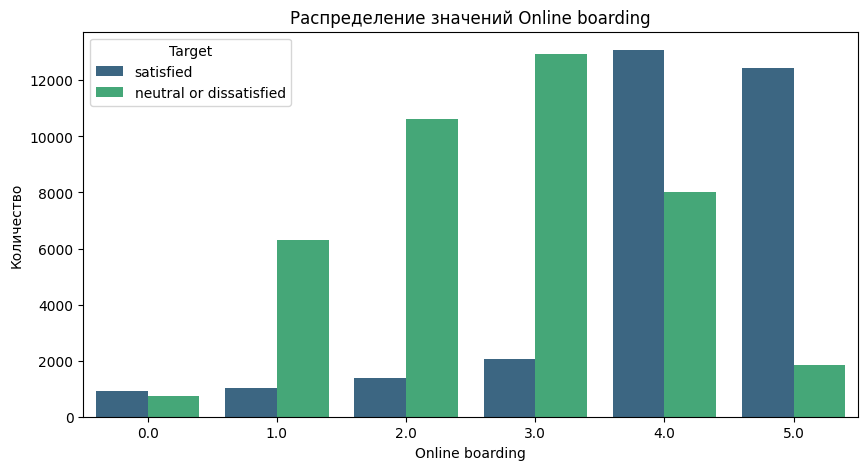

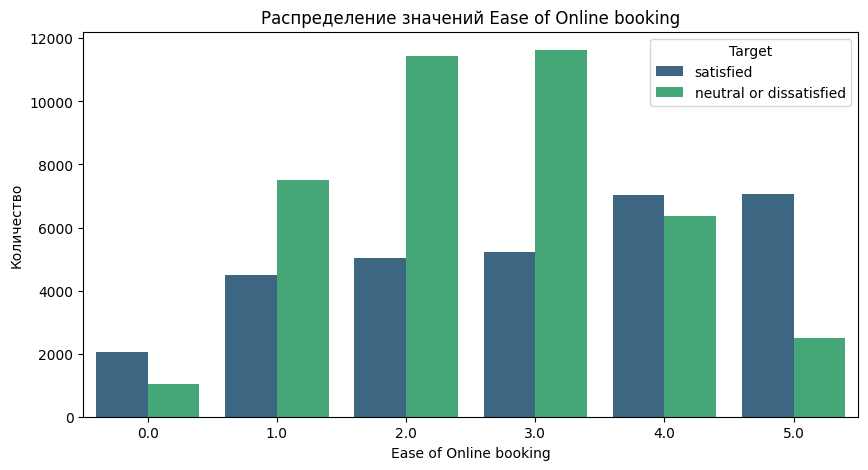

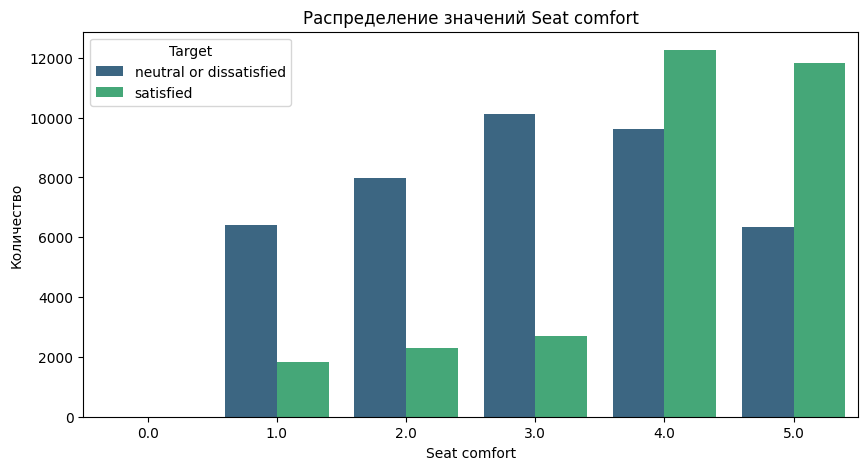

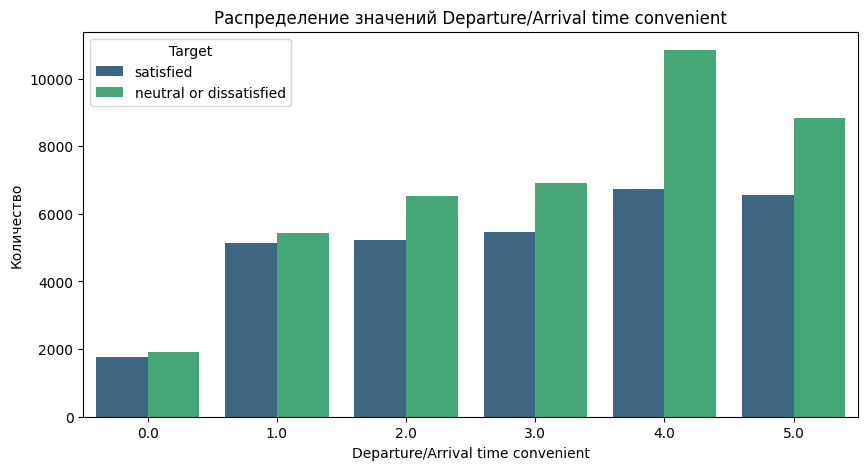

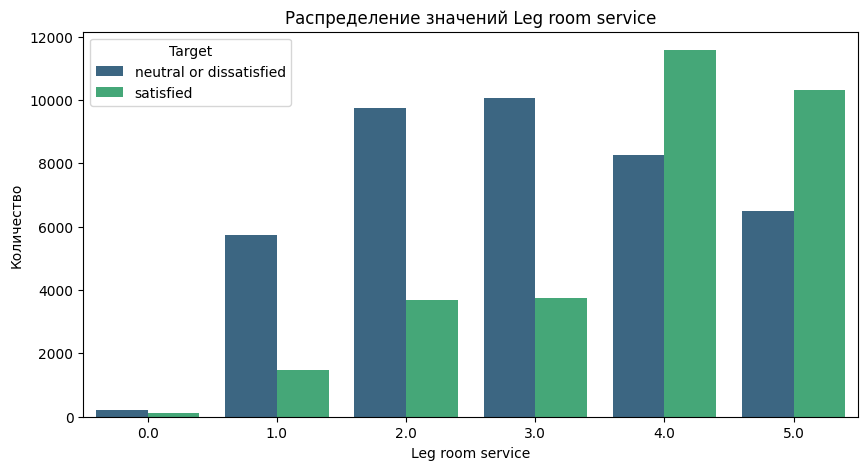

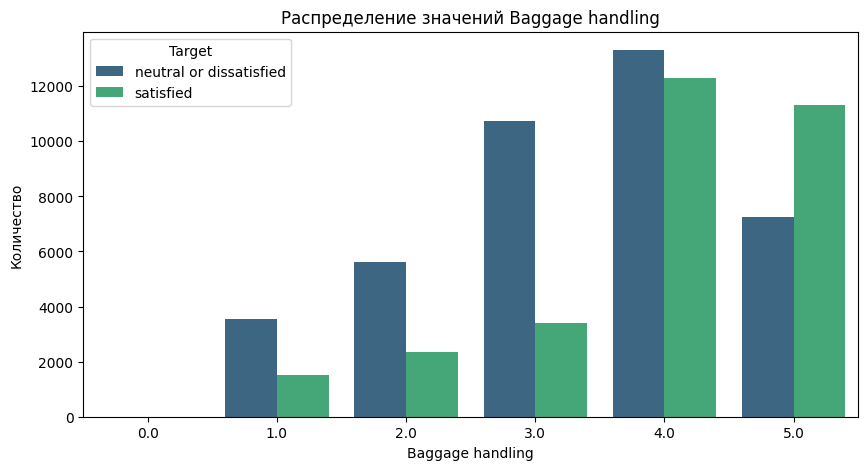

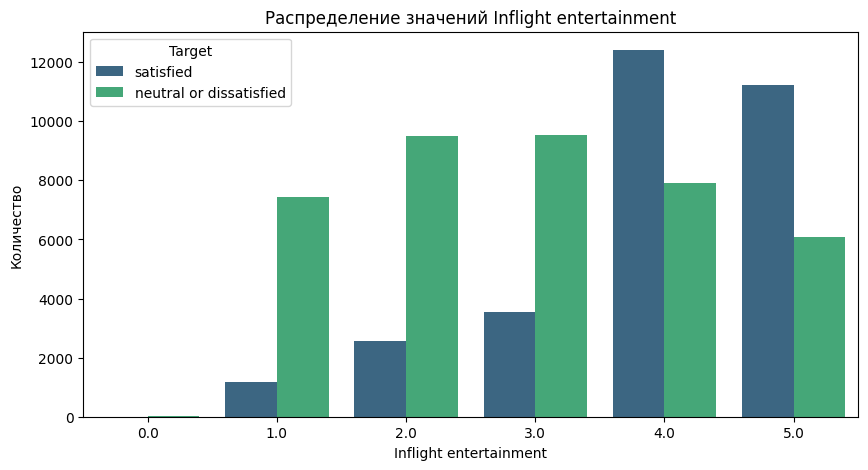

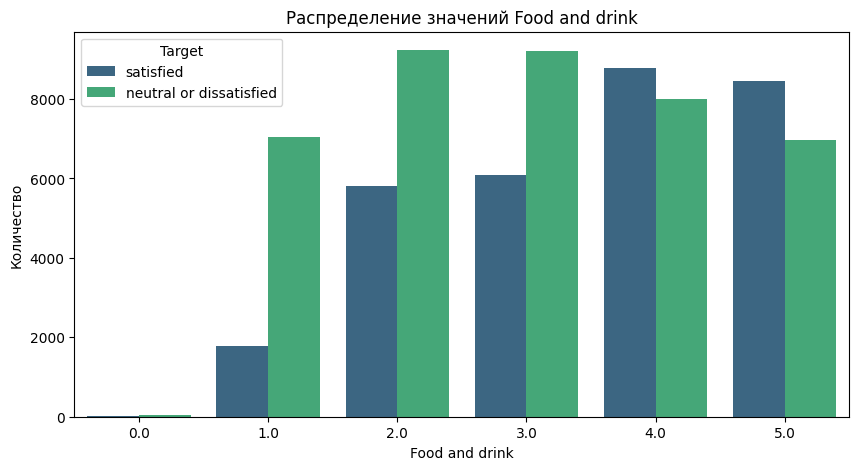

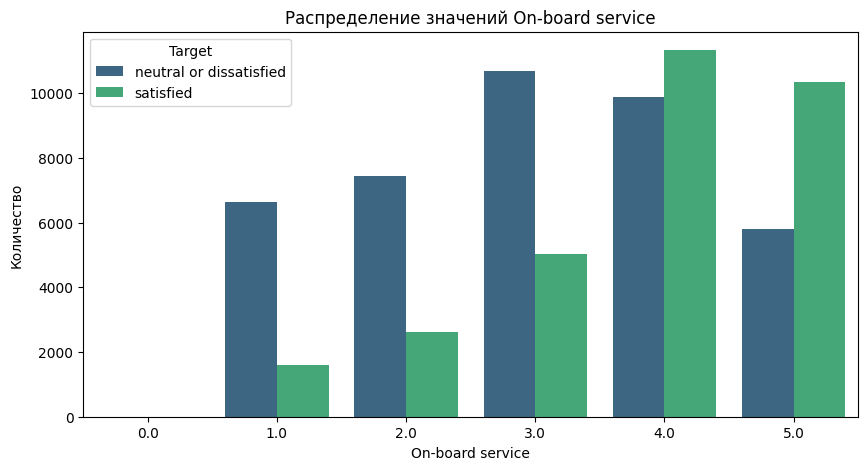

In [32]:
plot_ordinal(ordinal_cols, X_train, y_train)

In [33]:
# visualize y_train

### **Задание 8 (0.2 балла)**

Сделайте выводы по построенным графикам.

Не забудьте упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки


```
Распределение признаков:
- Custumer Type: в тренировочных данных больше клиентов типа "Loyal Custumer", т.е. лояльных клиентов;
- Type of Travel: клиенты типа "Business travel" в большой степени удовлетварены полетом, это логично, но перекос слишком большой;
- class: похожая история как и с "Type of Travel", клиенты бизнес-класса намного чаще довольны полетом.

Континуальные признаки:
- Departure Delay in Minutes, Arrival Delay in Minutes: по графикам распределния видно, что данные признаки не влияют
на удовлетворенность полета клиентом, практически в равной мере есть как двольные клиенты, так и нет, при равных значений признаков.
- Flight Distance: по графику видно, что клиенты чаще недовольны полетом, если расстояние полета до 1000 миль;
- А вот с возрастом клиентом интереснее: клиенты, которые чаще всего не довольны полетом, имеют возраст примерно 20-25 лет,
клиенты в возрасте 40+ лет чаще остаются довольны полетом (возможно, к этому возрасту уже можно позволить себе бизнес-класс :) )

Признаки с оценками сервисов клиентами:
- Больше всего клиентов, которые положительно оценили удобства сиденьев (4 и 5) и остались довольны полетом;
- Клиенты, которые высоко (4 и 5) оценили онлайн-интернет в итоге остались довольны полетом;
- Онлайн регистрацию большенство пользователей оценили высоко и по итогу остались довольны полетом;
- Также, по графикам еды и напитков можно сделать вывод, что качество питания влияет на оценку полета;

Если подытожить: клиенты, которые высоко оценили сервисы во время перелета, по итогу остались в целом им довольны.
```



### **Бонус (0.1 балла)**
По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест.

In [34]:
def plot_categorical_distributions(cols, train, val, test):
    """
    Сравнивает распределения категориальных/порядковых признаков для train, val и test.
    """
    for col in cols:
        plt.figure(figsize=(10, 6))

        train_percent = train[col].value_counts(normalize=True) * 100
        val_percent = val[col].value_counts(normalize=True) * 100
        test_percent = test[col].value_counts(normalize=True) * 100

        percent_df = pd.DataFrame({
            'Train': train_percent,
            'Validation': val_percent,
            'Test': test_percent
        }).T

        percent_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='viridis', legend=True)
        plt.title(f'Распределение {col}')
        plt.ylabel('Процент')
        plt.xlabel('Набор данных')
        plt.legend(title='Значения')
        plt.show()

<Figure size 1000x600 with 0 Axes>

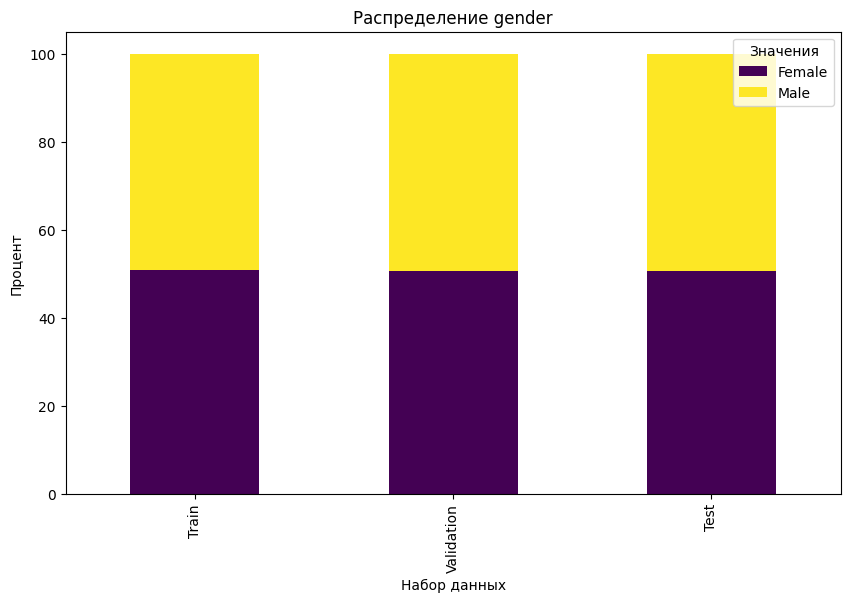

<Figure size 1000x600 with 0 Axes>

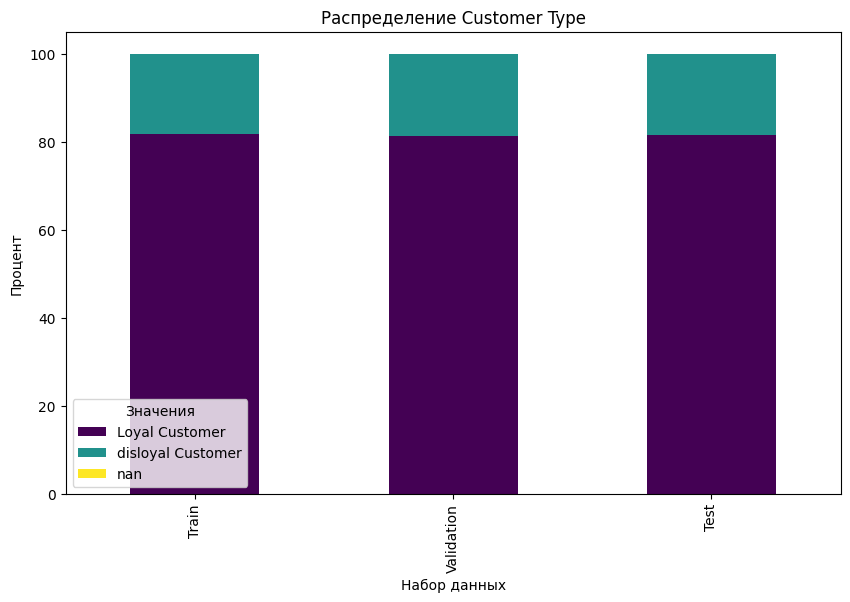

<Figure size 1000x600 with 0 Axes>

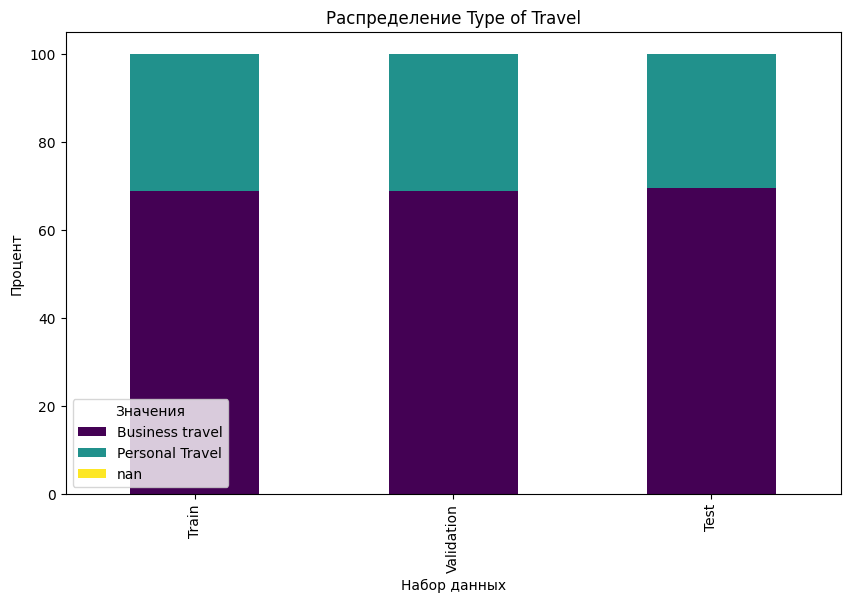

<Figure size 1000x600 with 0 Axes>

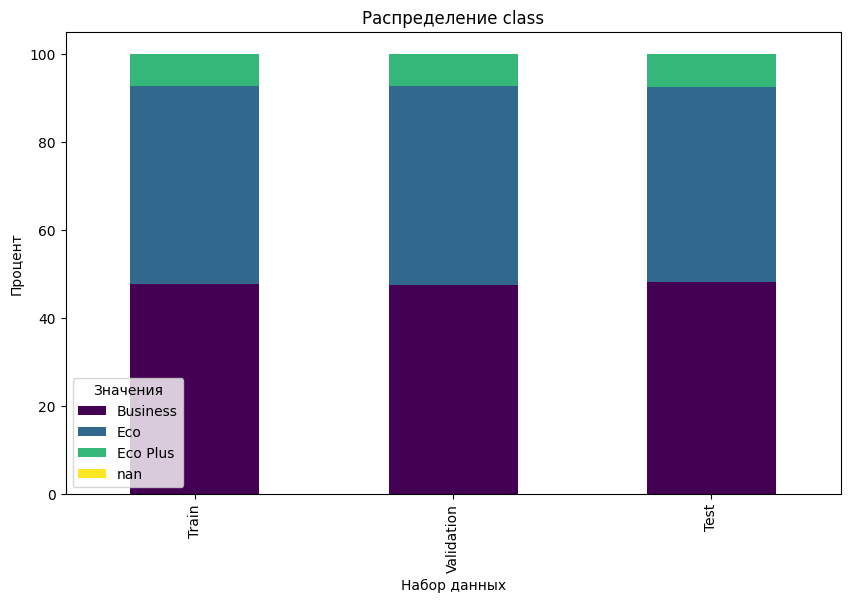

In [35]:
# Для категориальных признаков
plot_categorical_distributions(categorical_cols, X_train, X_val, df_test)

<Figure size 1000x600 with 0 Axes>

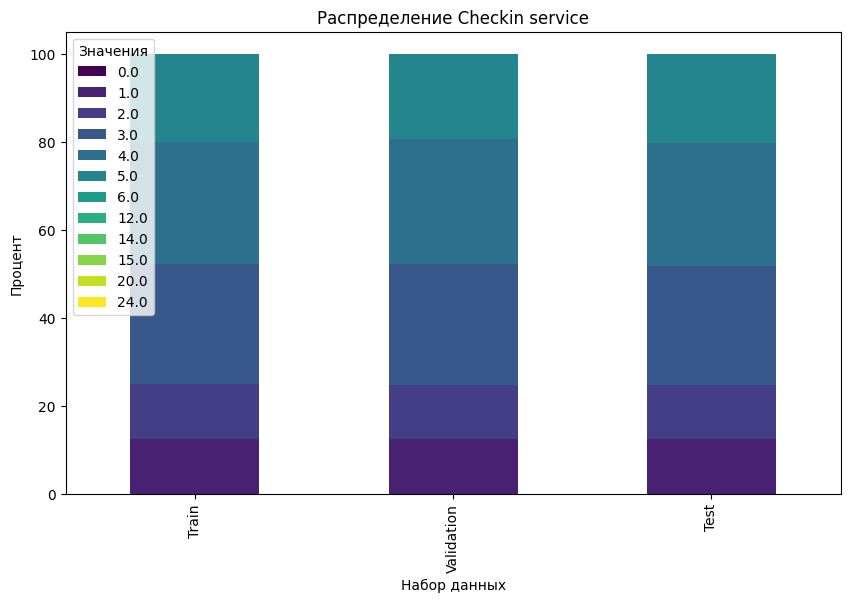

<Figure size 1000x600 with 0 Axes>

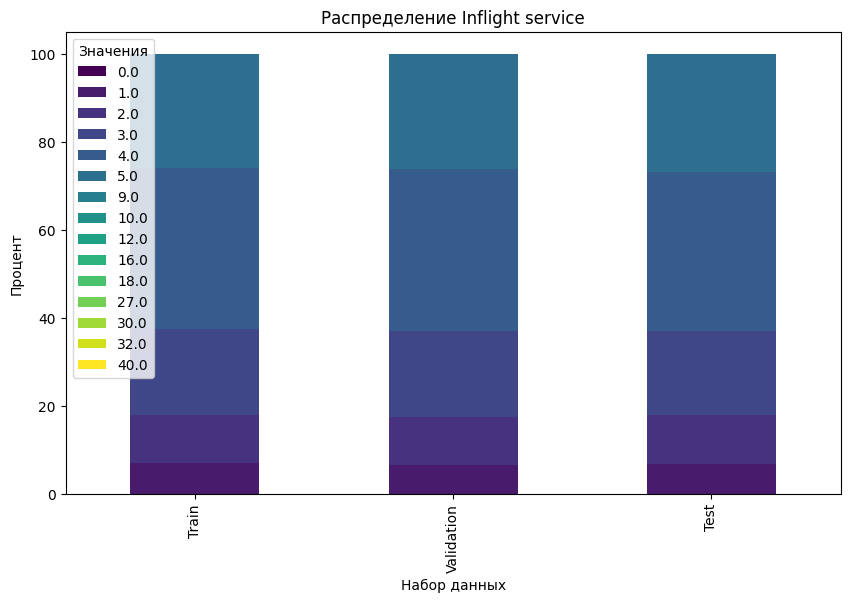

<Figure size 1000x600 with 0 Axes>

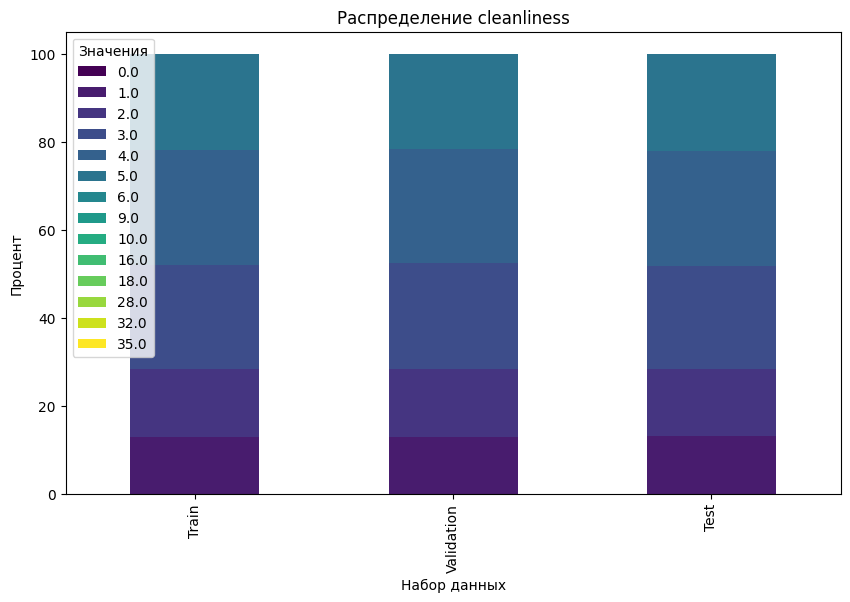

<Figure size 1000x600 with 0 Axes>

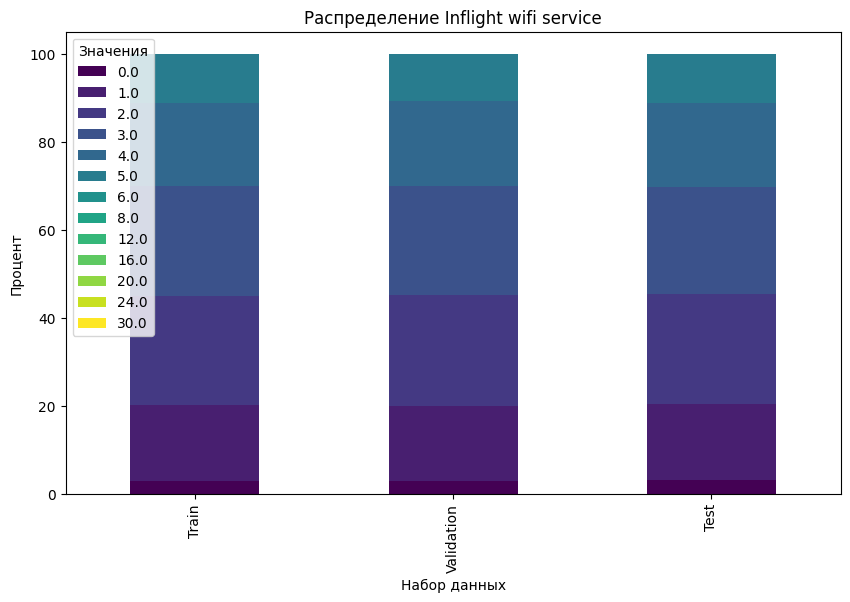

<Figure size 1000x600 with 0 Axes>

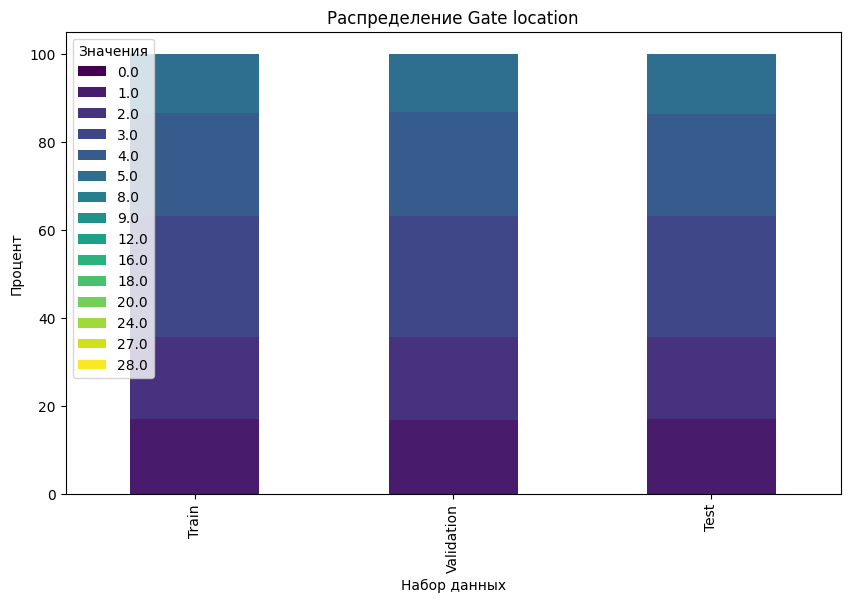

<Figure size 1000x600 with 0 Axes>

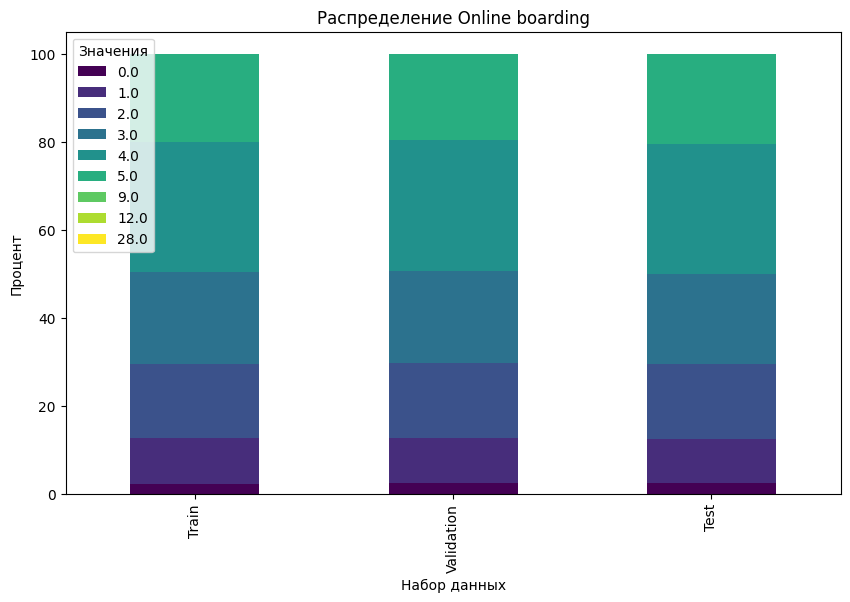

<Figure size 1000x600 with 0 Axes>

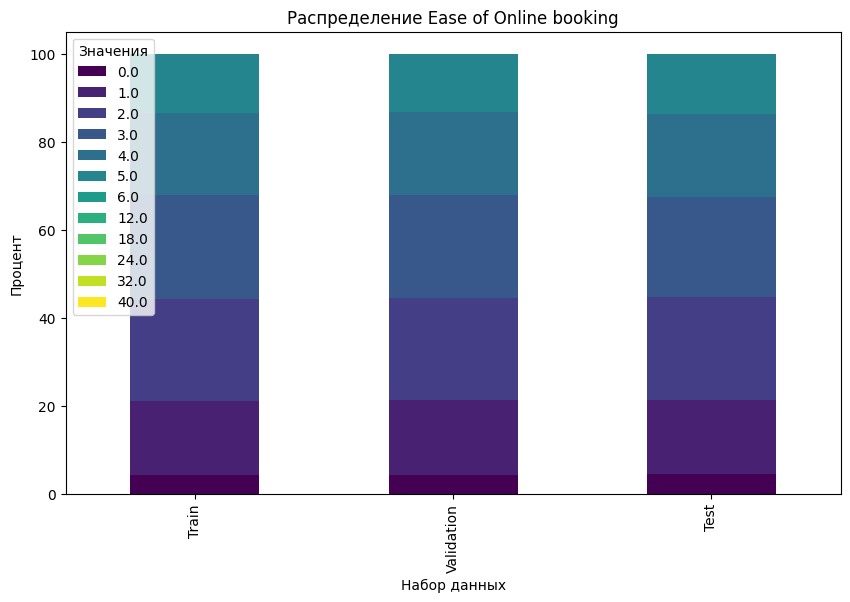

<Figure size 1000x600 with 0 Axes>

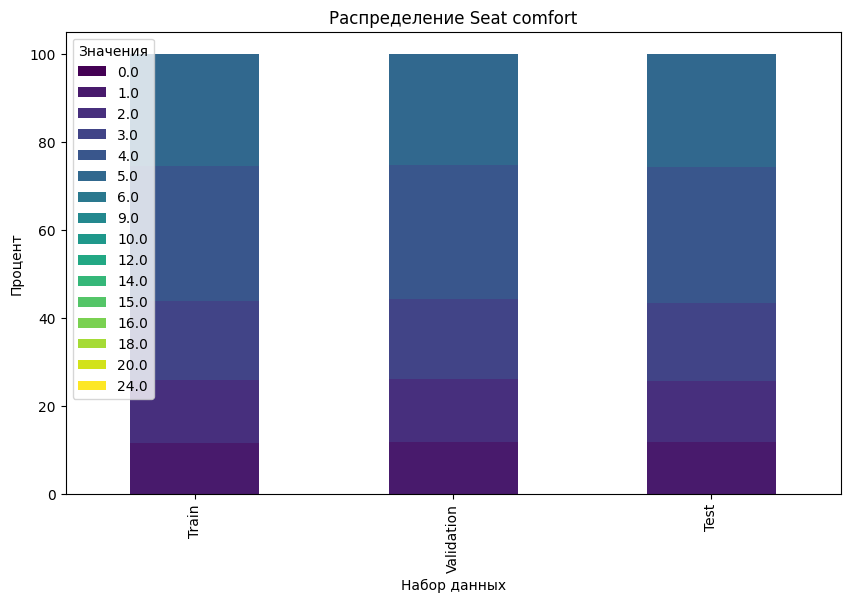

<Figure size 1000x600 with 0 Axes>

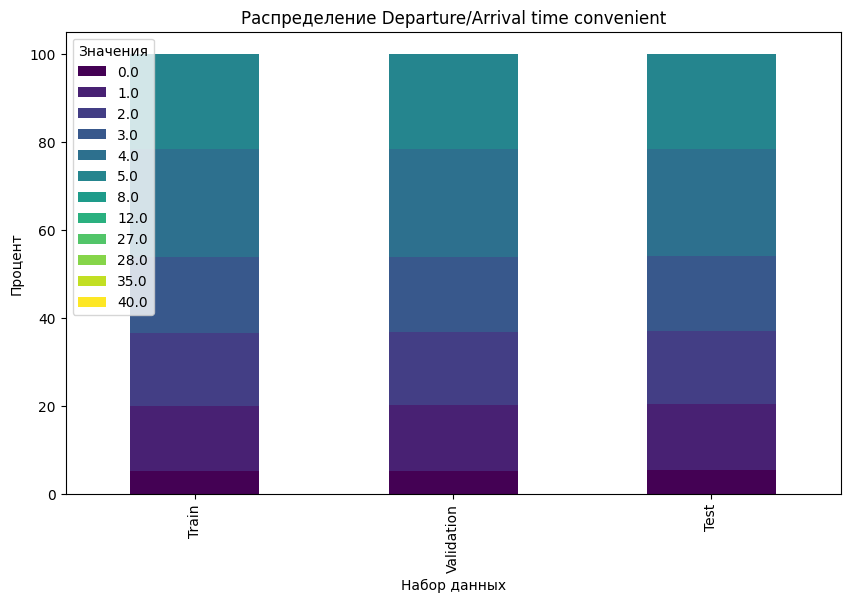

<Figure size 1000x600 with 0 Axes>

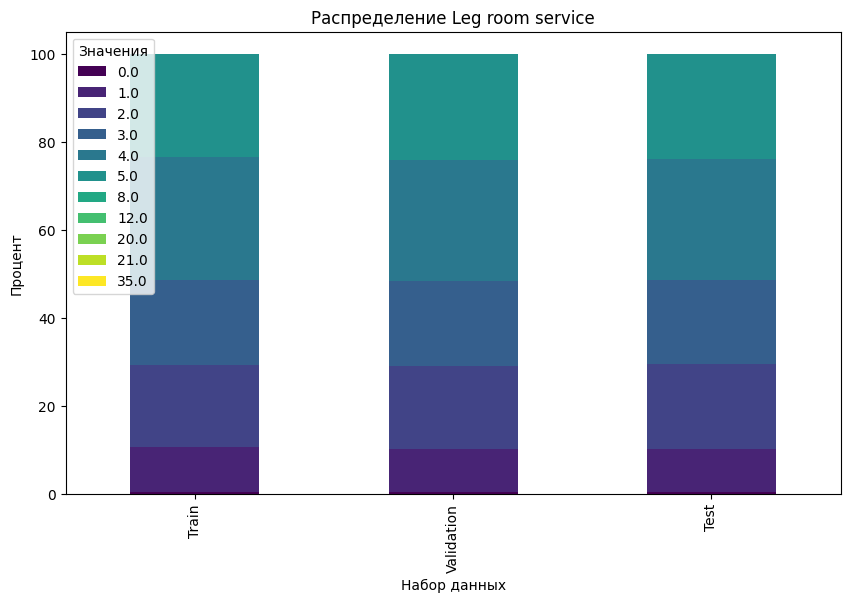

<Figure size 1000x600 with 0 Axes>

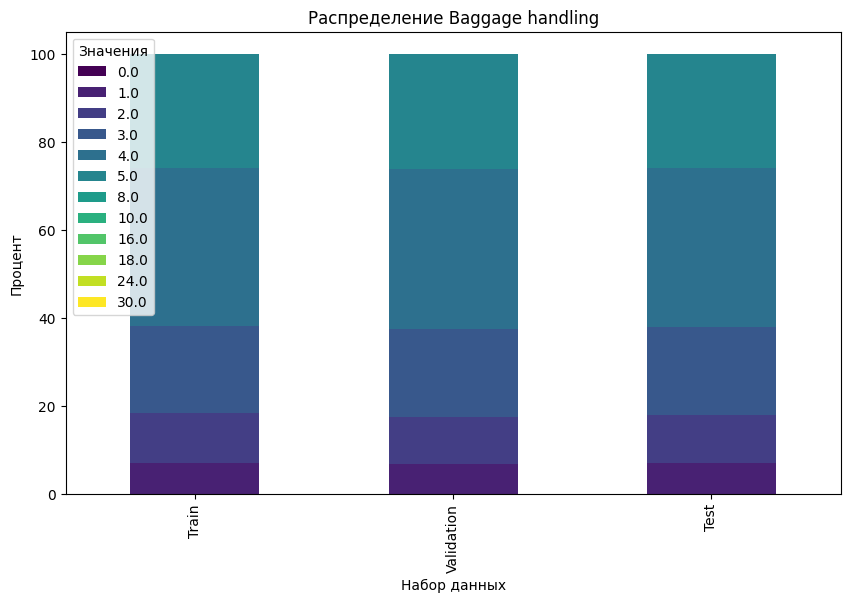

<Figure size 1000x600 with 0 Axes>

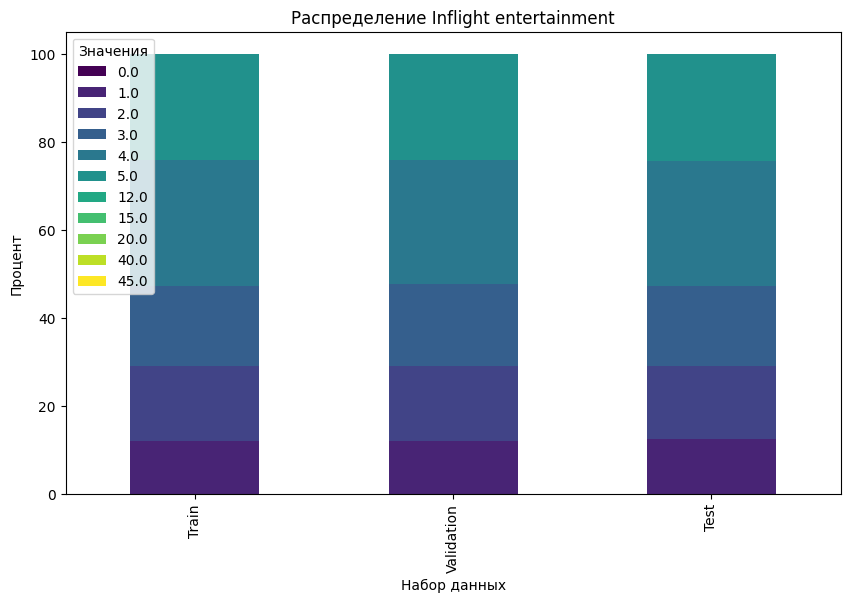

<Figure size 1000x600 with 0 Axes>

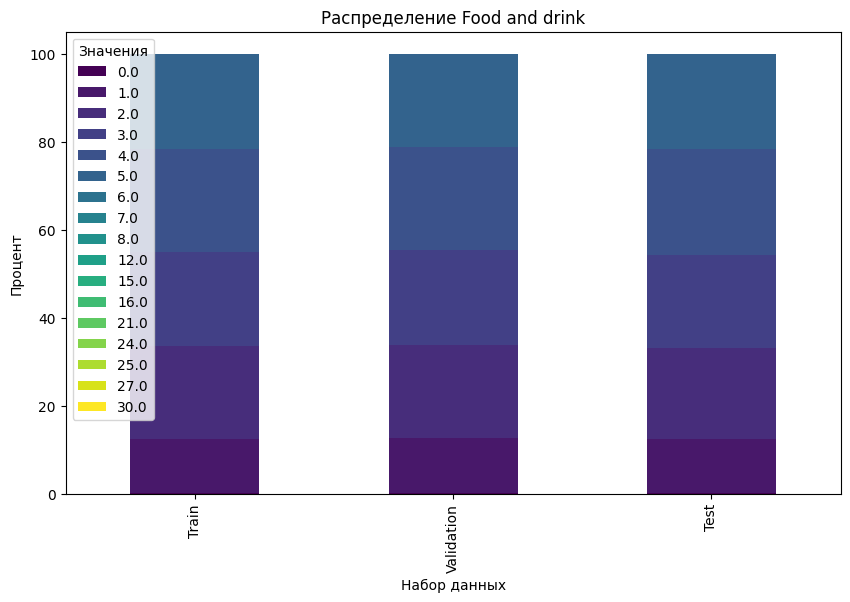

<Figure size 1000x600 with 0 Axes>

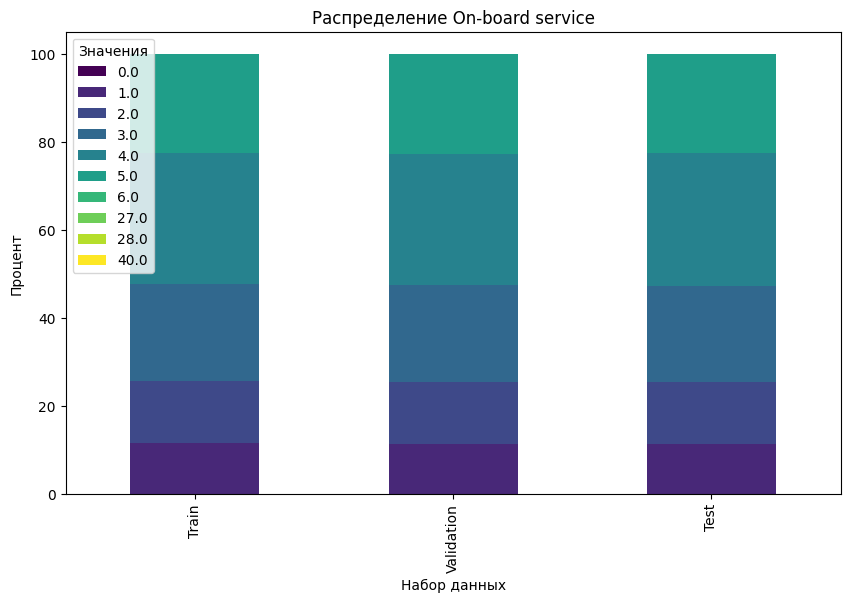

In [36]:
# Для порядковых признаков
plot_categorical_distributions(ordinal_cols, X_train, X_val, df_test)

```
По графикам видно, что категориальные и порядковые признаки распределены равномерно между train, test и val.
```

### **Задание 9 (0.25 балла)**

- Замените признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.
- Заново постройте графики континуальных признаков и сделайте вывод по преобразованию

Некоторые признаки полезно рассматривать в логарифмической шкале. Зачем? Она помогает анализировать большие диапазоны изменений (посмотрите на график логарифма).


In [37]:
X_train['Departure Delay in Minutes'] = np.log1p(X_train['Departure Delay in Minutes'])
X_train['Arrival Delay in Minutes'] = np.log1p(X_train['Arrival Delay in Minutes'])

Построение.

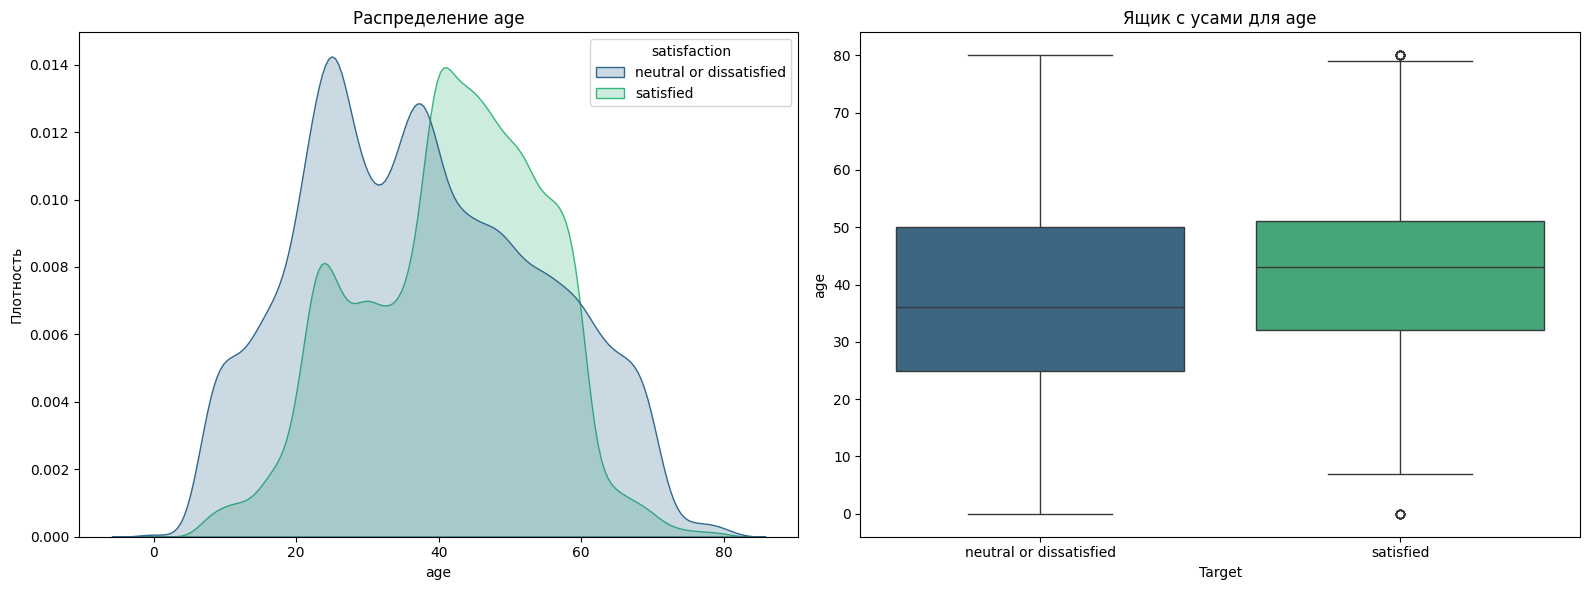

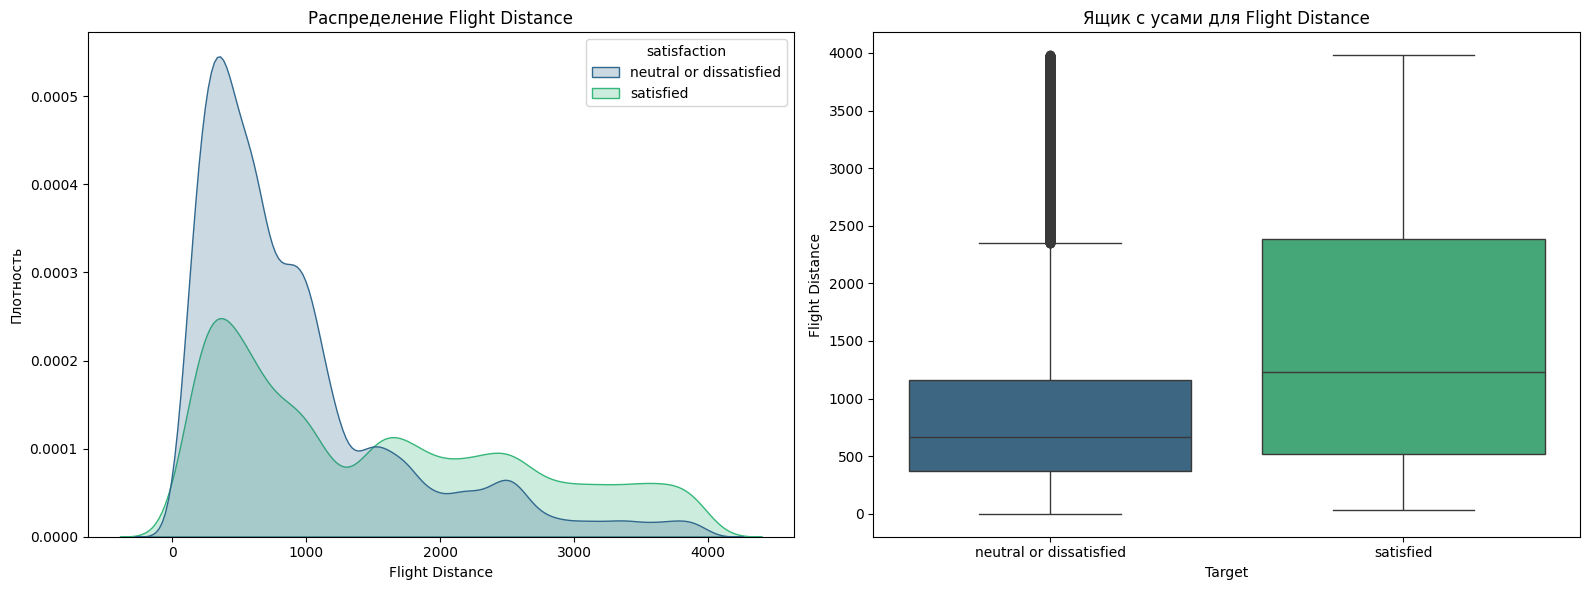

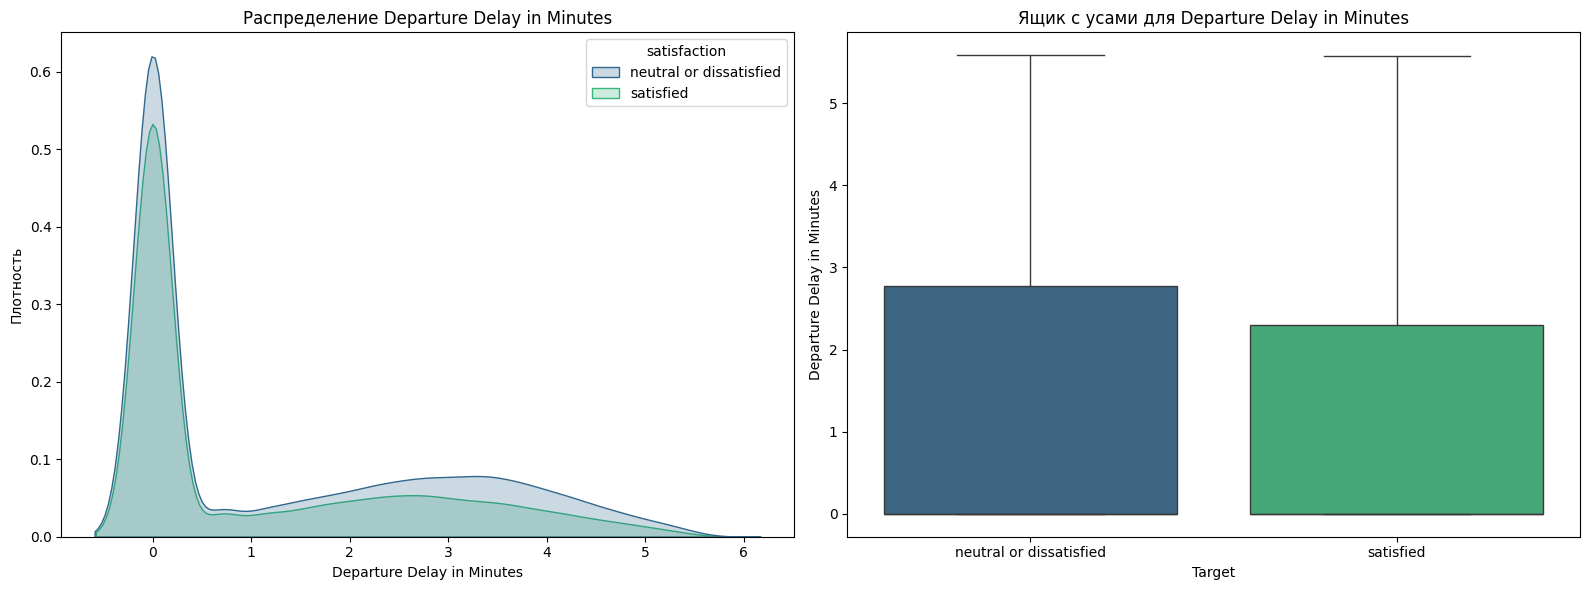

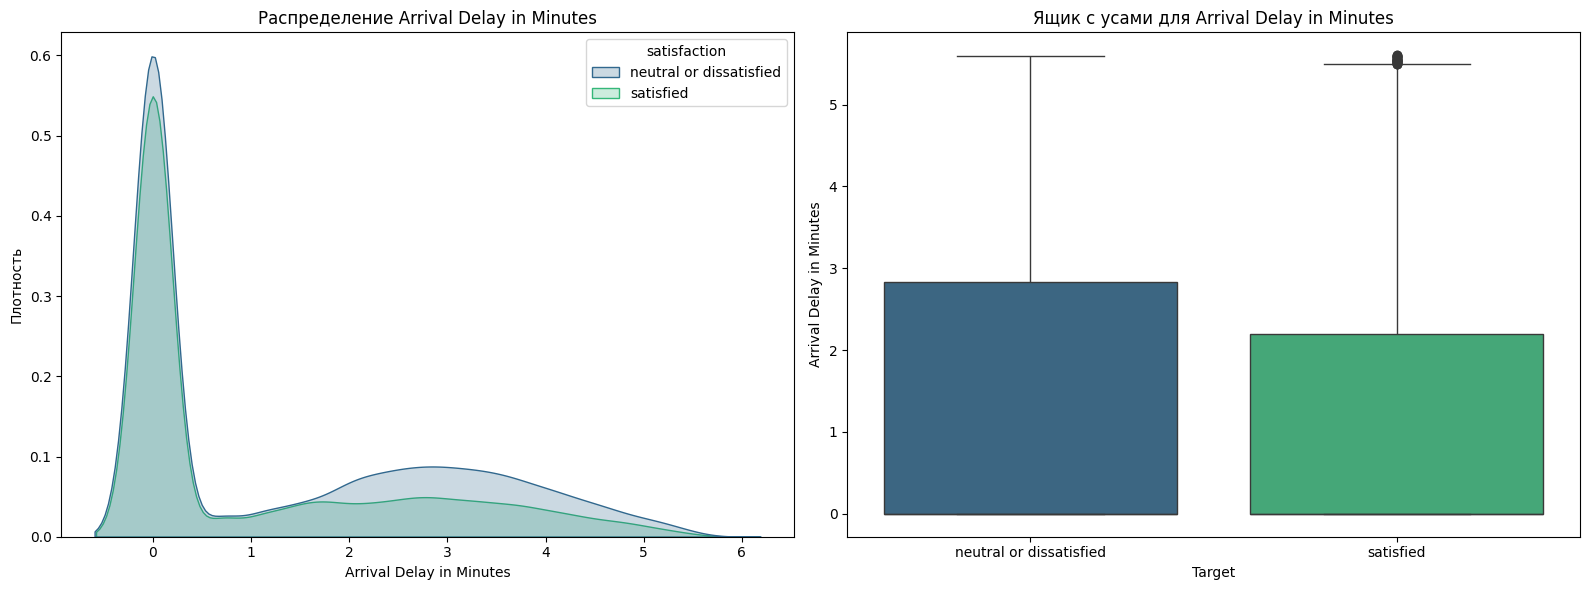

In [38]:
plot_continuous(continuous_cols, X_train, y_train)

```
По графикам выше видно:
- Клиенты в возрасте 40-60 лет чаще остаются довольны полетом;
- При расстояниях полета более 1.500 миль, клиенты чаще остаются довольны полетом;
- Другие два признака не влияют так сильно на удовлетворенность полетом.
```

### **Задание 10 (0.25 балла)**

Выше вы рассмотрели `boxplot` и графики распределений. Но иногда полезным оказывается `scatterplot, (pairplot)` в seabron. Проверьте, что покажет этот график в нашей задаче.

- Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом.

**Примечание:**
Наблюдений много, так что отрисовка графика вполне может занять несколько минут

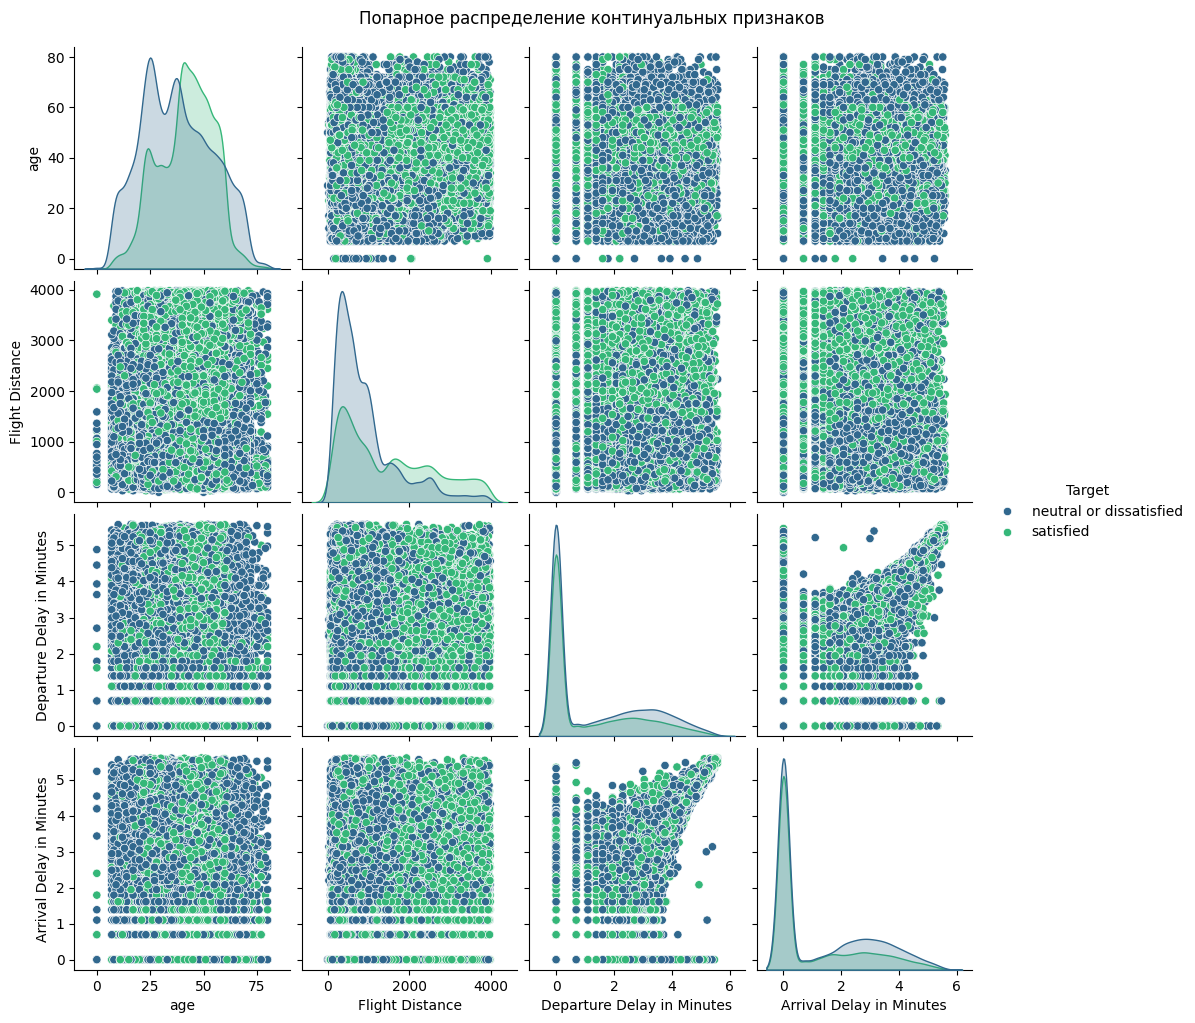

In [39]:
X_train['Target'] = y_train

sns.pairplot(
    data=X_train,
    vars=continuous_cols,
    hue='Target',
    palette='viridis',
    diag_kind='kde'
)

plt.suptitle('Попарное распределение континуальных признаков', y=1.02)
plt.show()

X_train.drop(columns=['Target'], inplace=True)

# **Часть 2. Decision Tree (3 балла)**

### **Задание 11 (0.4 балла)**

Предобработайте данные для алгоритма.
- Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0;
- Закодируйте категориальные признаки методом OHE;

In [40]:
# Кодируем таргет
y_train = (y_train == 'satisfied').astype(int)
y_val = (y_val == 'satisfied').astype(int)

In [41]:
# Кодируем признаки методом OHE
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

ohe.fit(X_train[categorical_cols])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[categorical_cols]).toarray(),
                           columns=ohe.get_feature_names_out(input_features=categorical_cols))

X_val_ohe = pd.DataFrame(ohe.transform(X_val[categorical_cols]).toarray(),
                         columns=ohe.get_feature_names_out(input_features=categorical_cols))

X_train = X_train.drop(columns=categorical_cols).reset_index(drop=True)
X_val = X_val.drop(columns=categorical_cols).reset_index(drop=True)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_val = pd.concat([X_val, X_val_ohe], axis=1)

### **Задание 12. (0.1 балла)**

- Обучите дерево решений с параметрами по умолчанию на имеющихся данных.
- Выведите `accuracy_score` для валидационной подвыборки

**Примечание**:

Здесь и далее, где вас просят что-нибудь обучить, выводите **везде** `accuracy_score` для валидационной подвыборки.

In [42]:
model_dtc = DecisionTreeClassifier()

model_dtc.fit(X_train, y_train)
y_pred = model_dtc.predict(X_val)

accuracy_dtc = accuracy_score(y_val, y_pred)

print(f'Accuracy на валидационной выборке (дерево решений): {accuracy_dtc:.4f}')

Accuracy на валидационной выборке (дерево решений): 0.9118


## **Анализ построенной модели**

### **Задание 13. (0.5 балла)**

- Посчитайте bias и variance для построенного дерева. Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [43]:
error_dt, bias_dt, var_dt = bias_variance_decomp(
    model_dtc,
    X_train.values, y_train.values,
    X_val.values, y_val.values,
    loss='0-1_loss',
    random_seed=42
)

print(f"Error: {error_dt:.4f}")
print(f"Bias: {bias_dt:.4f}")
print(f"Variance: {var_dt:.4f}")

Error: 0.0860
Bias: 0.0493
Variance: 0.0701


### **Задание 14. (0.2 балла)**

Проанализируйте структурные характеристики дерева.
- Какой глубины получилось дерево?
- Сколько в нем листьев?

In [44]:
depth = model_dtc.get_depth()
leaves = model_dtc.get_n_leaves()

print(f'Глубина дерева: {depth}')
print(f'Количество листьев: {leaves}')

Глубина дерева: 31
Количество листьев: 2094


### **Задание 15. (0.3 балла)**

Проанализируйте важность признаков, вычисляемую в дереве по построению.

- Выведите на экран barplot, демонстрирующий оценки важности признаков.
- Укажите, какие признаки оказались наиболее информативными?

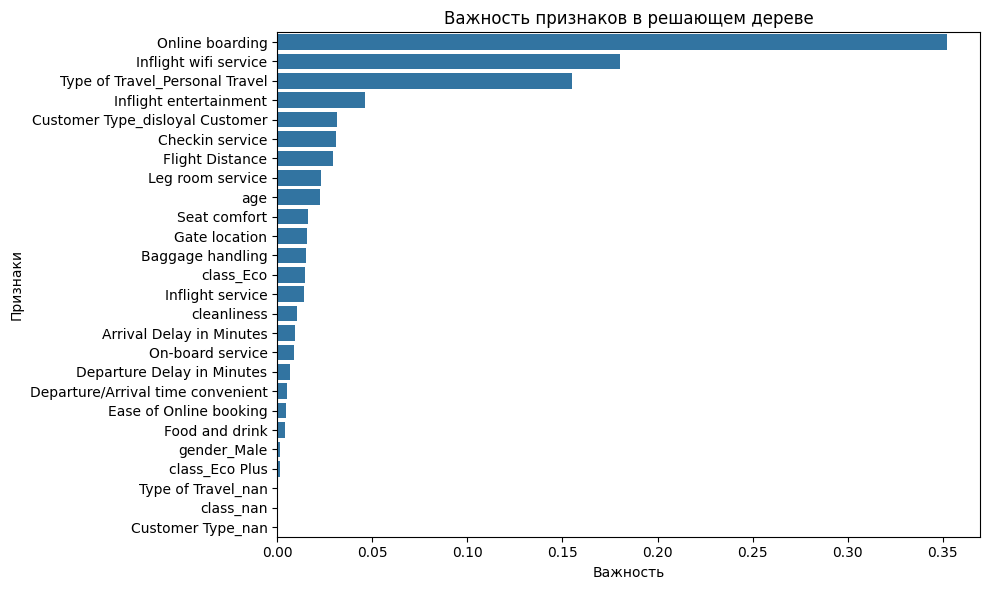

In [45]:
feature_importances = model_dtc.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков в решающем дереве')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

```
Наиболее важными для дерева стали признаки: Online boarding, Inflight wifi service и Type of Travel.
```  

### **Задание 16. (0.1 балла)**

- Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева.

In [46]:
top_2_features = importance_df['Feature'].head(2).values

X_train_top2 = X_train[top_2_features]
X_val_top2 = X_val[top_2_features]

model_top2 = DecisionTreeClassifier(max_depth=5, random_state=42)
model_top2.fit(X_train_top2, y_train)

y_val_pred_top2 = model_top2.predict(X_val_top2)
accuracy_top2 = accuracy_score(y_val, y_val_pred_top2)

print(f"Accuracy на валидационной выборке по 2 признакам (дерево решений): {accuracy_top2:.4f}")

Accuracy на валидационной выборке по 2 признакам (дерево решений): 0.8248


### **Задание 17. (0.15 балла)**

- С помощью graphviz визуализируйте получившееся новое дерево решений. Почему предикаты в нем не целые, а кратны 1/2?

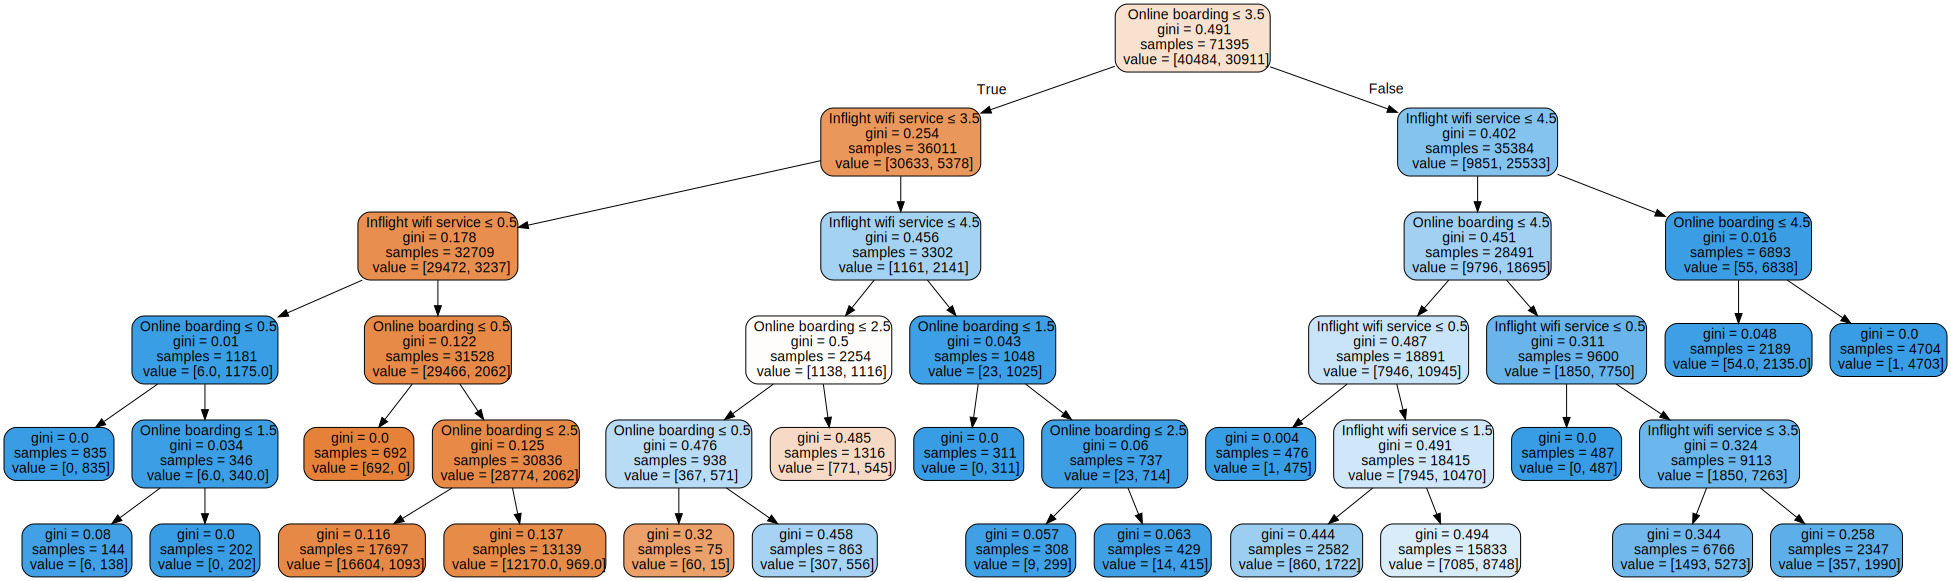

In [47]:
dot_data = export_graphviz(
    model_top2,
    feature_names=top_2_features,
    filled=True,
    rounded=True,
    special_characters=True
)

graph = Source(dot_data)
graph

```
Дерево решений вычислят вероятность классов как долю объектов одного класса в листьях.
```

*Гуглить — можно, но помните о культуре цитирования.*

### **Задание 18. (0.25 балла)**

- Теперь отобразите его функцией `plot_tree()` из sklearn.
- Проанализируйте — ссимметричным ли получилось дерево? И хорошо ли это, или нет?

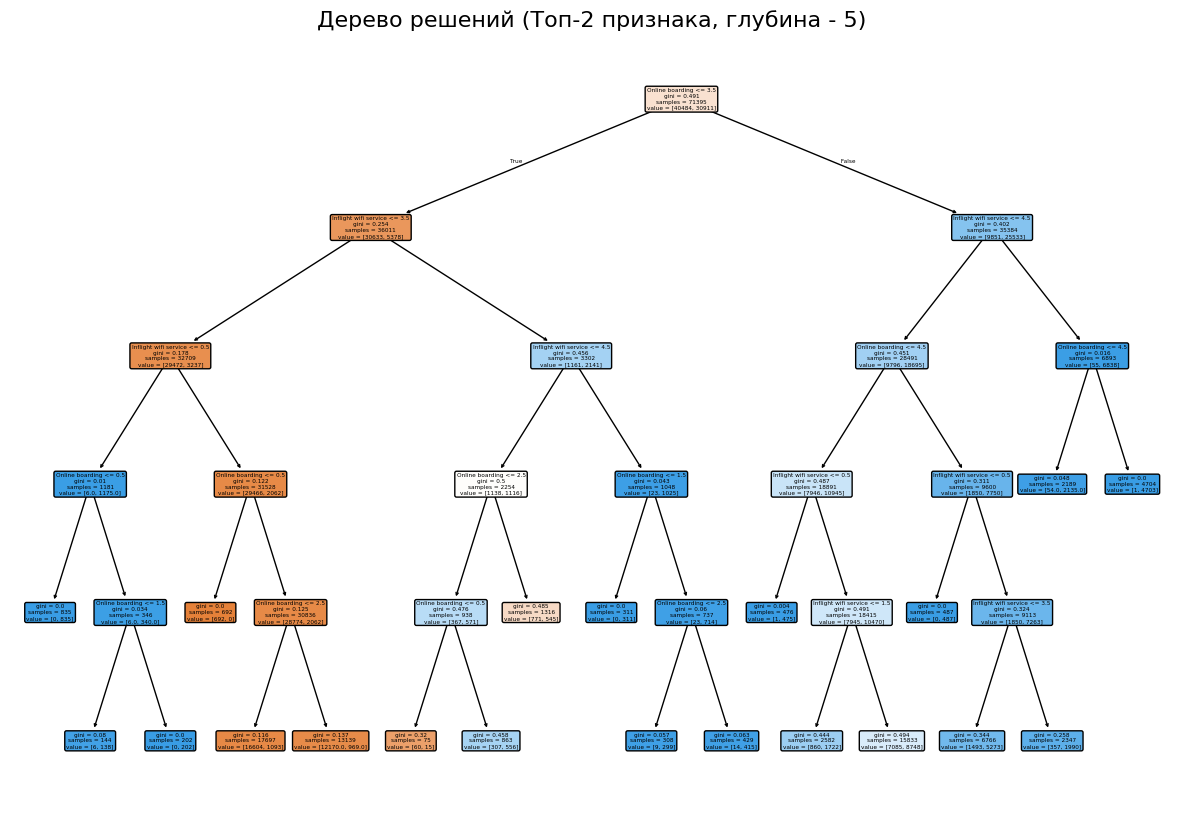

In [48]:
plt.figure(figsize=(15, 10))
plot_tree(
    model_top2,
    feature_names=top_2_features,
    filled=True,
    rounded=True
)
plt.title("Дерево решений (Топ-2 признака, глубина - 5)", fontsize=16)
plt.show()

```
Дерево получилось несимметричным. Трудно сказать хорошо это или плохо.
- Плюсы несимметричного дерева: если данные несбалансированы, то модель правильно отдает предпочтение самому информативному признаку, а также,
несимметричность может отображать сложность данных, отражая реальную структуру.

- Минусу несимметричного дерева: какой-то признак может сильно доминировать из-за шума в данных, а также, несимметричные деревья сложно
интерпритируемы.
```

### **Задание 19. (0.5 балла)**

- Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева. Отметьте на графике только первые 100 объектов обучающей выборки

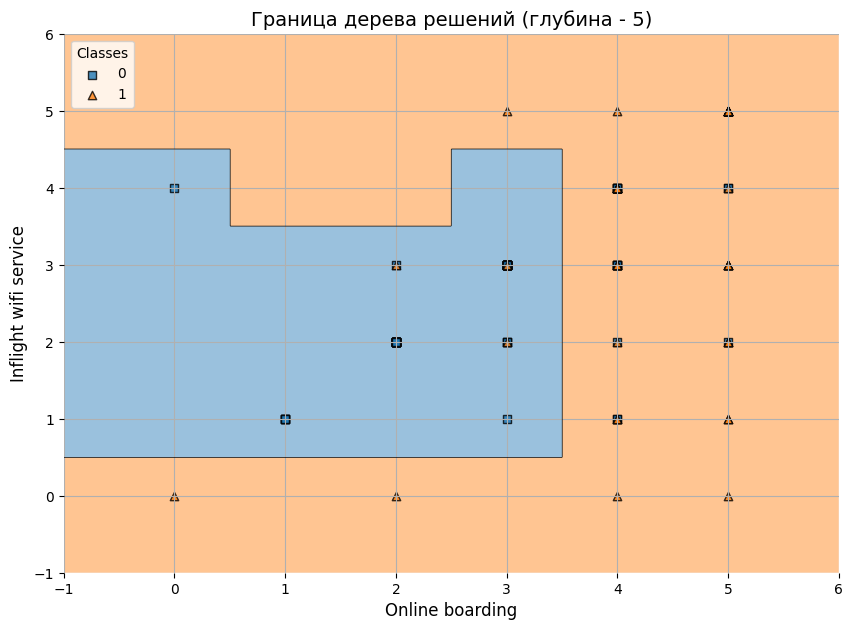

In [49]:
X_sample_100 = X_train[top_2_features].iloc[:100].values
y_sample_100 = y_train.iloc[:100].values

plt.figure(figsize=(10, 7))
plot_decision_regions(X_sample_100, y_sample_100, clf=model_top2, legend=2)

plt.title("Граница дерева решений (глубина - 5)", fontsize=14)
plt.xlabel(top_2_features[0], fontsize=12)
plt.ylabel(top_2_features[1], fontsize=12)
plt.legend(loc="upper left", title="Classes")
plt.grid()
plt.show()

### **Деревья решений. Теоретическая вставка**

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это!

In [50]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

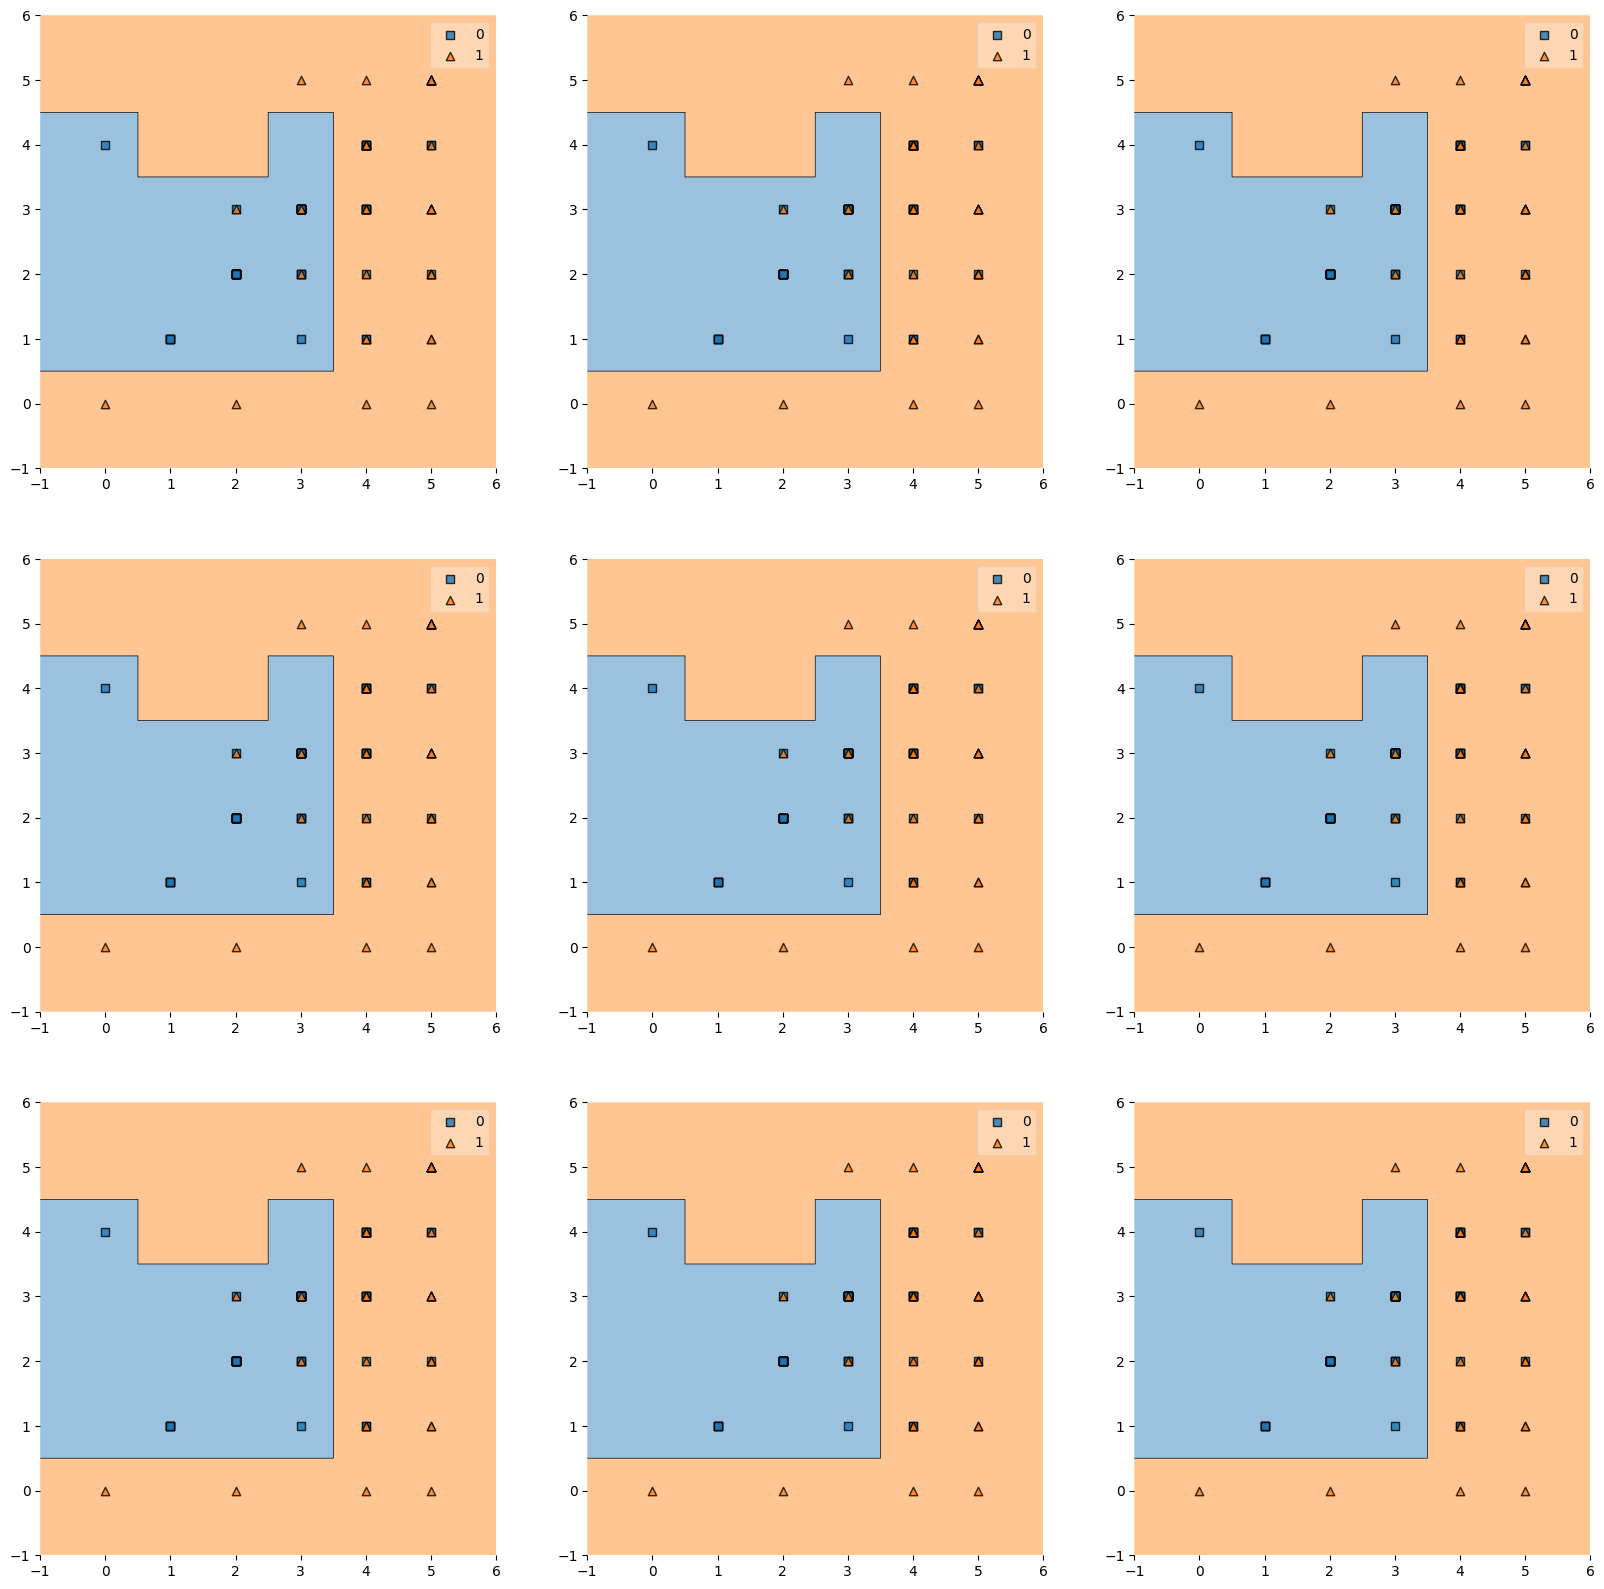

In [51]:
fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train[top_2_features].index, size=X_train[top_2_features].shape[0] - 1000, replace=False)

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train[top_2_features].iloc[inds, :], y_train.iloc[inds])

        plot_decision_regions(
            clf=tree_exp,
            X=X_train[top_2_features].iloc[:100, :].values,
            y=y_train.iloc[:100].values,
            ax=ax[row][col]
        )
plt.show()

**Смотрите как двигается гранится, а ведь мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!**

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [52]:
%%time
depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train, y_train)
    y_predicted_train = DT.predict(X_train)
    y_predicted_val = DT.predict(X_val)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

CPU times: user 5.52 s, sys: 10.3 ms, total: 5.53 s
Wall time: 5.51 s


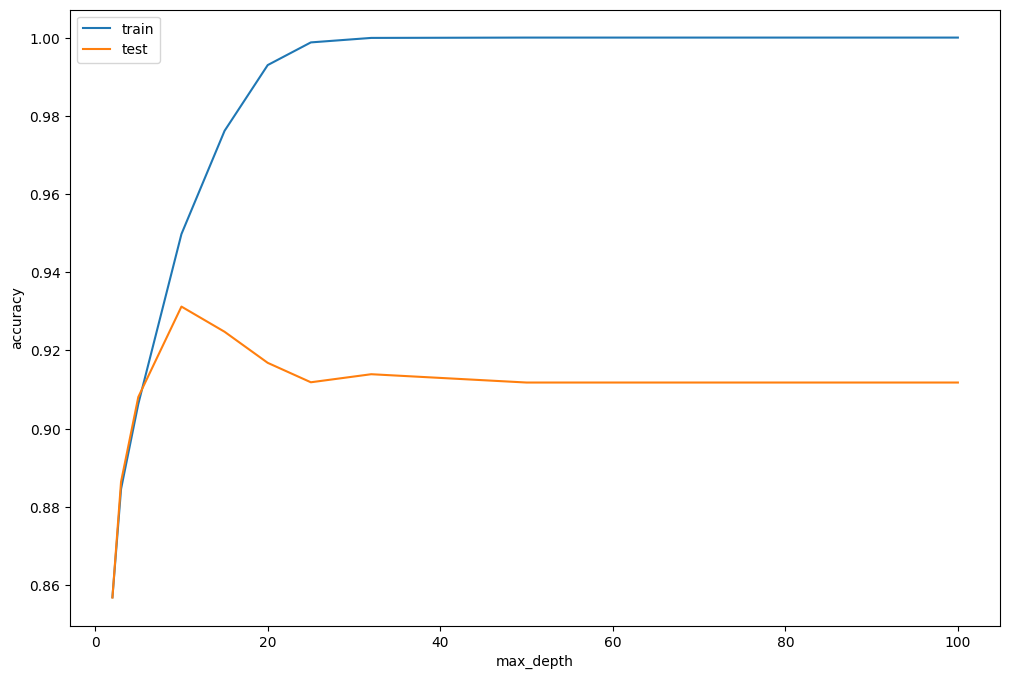

In [53]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## **Возвращение к задаче**

### **Задание 20. (0.4 балла)**

- На кроссвалидации подберите оптимальные гиперпараметры для дерева решений *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*.
- Удалось ли улучшить качество предсказаний подбором гиперпараметров?

In [54]:
# param_grid = {
#     'max_depth': [3, 5, 10, 15, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': [None, 'sqrt', 'log2']
# }


# dtc = DecisionTreeClassifier(random_state=42)
# grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
# grid_search.fit(X_train, y_train)

# print("Лучшие гиперпараметры:", grid_search.best_params_)

In [55]:
# best_model = grid_search.best_estimator_

with open('DT.pkl', 'rb') as f:
  best_model = pickle.load(f)

y_val_pred = best_model.predict(X_val)
print(f"Accuracy на валидационной выборке (дерево решений): {accuracy_score(y_val, y_val_pred):.4f}")

Accuracy на валидационной выборке (дерево решений): 0.9279


```
Благодаря подбору гиперпараметров удалось чуть-чуть улучшить значение метрики accuracy c 0.91 до 0.93.
```

### **Задание 21. (0.1 балла)**

- Сохраните лучшее дерево в pickle

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [56]:
# with open('DT.pkl', 'wb') as f:
#   pickle.dump(best_model, f)

# **Часть 3. Random Forest (4.25 балла)**

### **Задание 22. (0.05 балла)**
- Обучите случайный лес с параметрами по умолчанию

In [57]:
rf_base = RandomForestClassifier(random_state=42)
rf_base.fit(X_train, y_train)

y_val_pred = rf_base.predict(X_val)

print(f"Accuracy на валидационной выборке (случайный лес): {accuracy_score(y_val, y_val_pred):.4f}")

Accuracy на валидационной выборке (случайный лес): 0.9609


### **Задание 23. (0.15 балла)**
- Выведите калибровочную кривую для полученного ансамбля

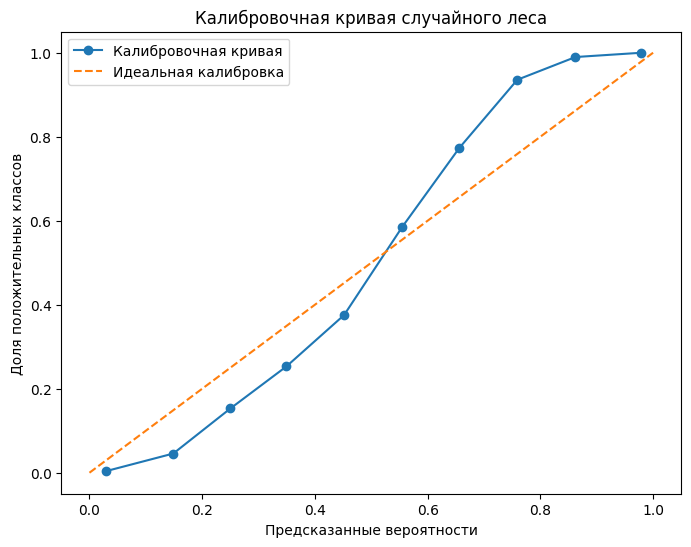

In [58]:
from sklearn.calibration import calibration_curve

y_val_proba = rf_base.predict_proba(X_val)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_val_proba, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Калибровочная кривая')
plt.plot([0, 1], [0, 1], linestyle='--', label='Идеальная калибровка')
plt.title('Калибровочная кривая случайного леса')
plt.xlabel('Предсказанные вероятности')
plt.ylabel('Доля положительных классов')
plt.legend()
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

### **Задание 24. (0.4 балла)**

- Вспомните (или выведите), корректно ли деревья предсказывают вероятности?

```
Деревья предсказывают вероятность, основываясь на пропорции объектов в листе, куда попал новый объект.
Это делает предсказание не точным, особенно, если присутсвует сильный дисбаланс классов.
```



### **Задание 25. (0.15 балла)**
- Обучите логистическую регрессию так, чтобы она сошлась
- Отобразите её калибровочную кривую

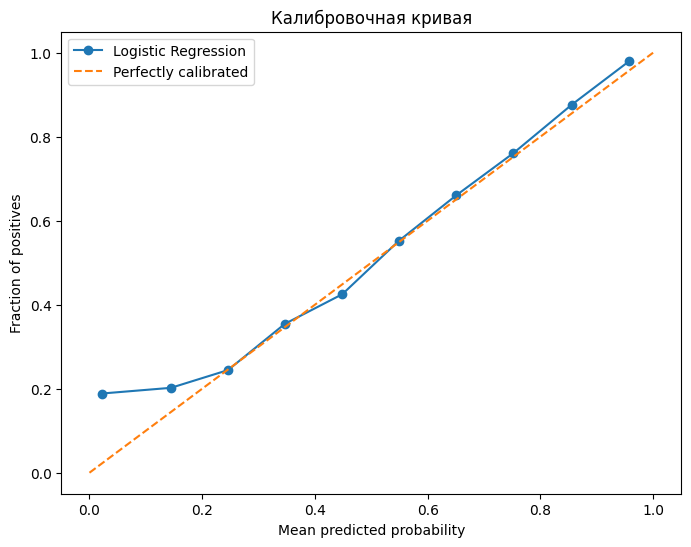

In [59]:
logreg = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42)
logreg.fit(X_train, y_train)

y_prob = logreg.predict_proba(X_val)[:, 1]

fraction_of_positives, mean_predicted_value = calibration_curve(y_val, y_prob, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Калибровочная кривая')
plt.legend()
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

### **Задание 26. (0.2 балла)**
- Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?

```
Лог. рег. корректно предсказывает вероятности, т.к. ее выходная функция (сигмоида) ограничивает значения в интервале от 0 до 1,
интерпритируемые как вероятности.
```


### **Задание 27. (0.35 балла)**

Предлагаем вам попробовать откалибровать вероятности обученного случайного леса!

- Откалибруйте вероятности, при помощи логистической и изотонической регрессий.
- Интерпретируйте полученные результаты

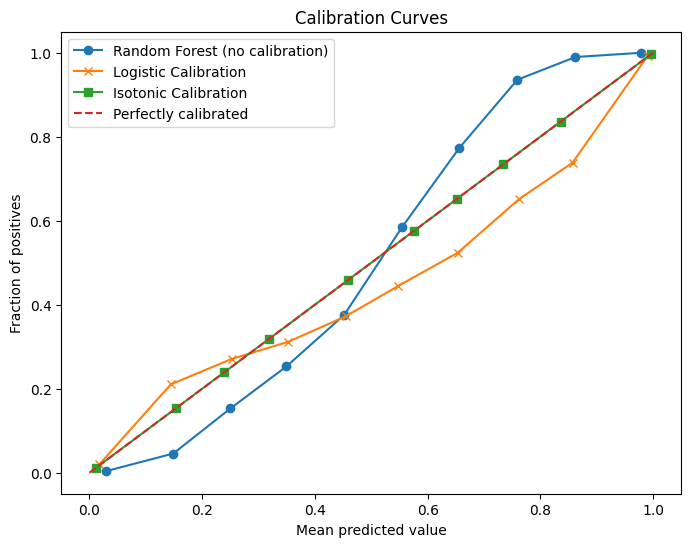

In [60]:
from sklearn.calibration import CalibratedClassifierCV

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Калибровка с помощью логистической регрессии
calibrated_rf_logistic = CalibratedClassifierCV(rf, method='sigmoid', cv='prefit')
calibrated_rf_logistic.fit(X_val, y_val)

# Калибровка с помощью изотонической регрессии
calibrated_rf_isotonic = CalibratedClassifierCV(rf, method='isotonic', cv='prefit')
calibrated_rf_isotonic.fit(X_val, y_val)

y_prob_rf = rf_base.predict_proba(X_val)[:, 1]
y_prob_logistic = calibrated_rf_logistic.predict_proba(X_val)[:, 1]
y_prob_isotonic = calibrated_rf_isotonic.predict_proba(X_val)[:, 1]

fig, ax = plt.subplots(figsize=(8, 6))
fraction_of_positives_rf, mean_predicted_value_rf = calibration_curve(y_val, y_prob_rf, n_bins=10)
fraction_of_positives_logistic, mean_predicted_value_logistic = calibration_curve(y_val, y_prob_logistic, n_bins=10)
fraction_of_positives_isotonic, mean_predicted_value_isotonic = calibration_curve(y_val, y_prob_isotonic, n_bins=10)

ax.plot(mean_predicted_value_rf, fraction_of_positives_rf, marker='o', label='Random Forest (no calibration)')
ax.plot(mean_predicted_value_logistic, fraction_of_positives_logistic, marker='x', label='Logistic Calibration')
ax.plot(mean_predicted_value_isotonic, fraction_of_positives_isotonic, marker='s', label='Isotonic Calibration')
ax.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

ax.set_xlabel('Mean predicted value')
ax.set_ylabel('Fraction of positives')
ax.set_title('Calibration Curves')
ax.legend()

plt.show()

```
Методы логистической и изотонической калибрации дают более высокие значения показателя позитивности по сравнению с калибровкой без неё.
```

### **Задание 28. (0.2 балла)**
- Опишите другие возвожные подходы к калибровке вероятностей (со ссылками на источники)

```
- Гистограммная калибровка: метод делит предсказанные вероятности на интервалы и для каждого интервала вычисляет ср. значение истинных меток,
что позволяет скорректировать вероятности, особенно когда модель склонна к переоценке или недооценке вероятностей.

- Калибровка Платта: подход заключается в том, что на основе выходных вероятностей модели обучается логистическая регрессия,
которая преобразует эти вероятности в более точные.

Источник: https://education.yandex.ru/handbook/ml/article/kak-ocenivat-veroyatnosti

- Деревья калибровки: метод строит на исходных признаках решающее дерево (не очень глубокое), далее в каждом листе обучает
логистическую регрессию на одном признаке – на оценках калибруемого алгоритма и подрезает дерево, минимизируя ошибку.

Источник: https://alexanderdyakonov.wordpress.com/2020/03/27/

```


### **Задание 29. (0.5 баллa)**

Проанализируйте лес.
- Посчитайте разброс и смещение полученного случайного леса (до калибровки).
- Оличаются ли они от полученных для дерева решений?
- Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?

> Уменьшила объем данных, чтобы ускорить процесс расчета:

In [61]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=100)
model_rf.fit(X_train[:1000], y_train[:1000])

error_rf, bias_rf, var_rf = bias_variance_decomp(
    model_rf,
    X_train.values[:1000], y_train.values[:1000],
    X_val.values[:1000], y_val.values[:1000],
    loss='0-1_loss',
    random_seed=42
)

print(f"Error: {error_rf:.4f}")
print(f"Bias: {bias_rf:.4f}")
print(f"Variance: {var_rf:.4f}")

Error: 0.0771
Bias: 0.0690
Variance: 0.0248


```
- Метрики для случайного леса отличаются от дерева решений. У случайного леса меньше ошибка, меньше разброс, но больше смещение.
- Отличия соответсвуют теории: случайный лес обычно имеет более низкий разброс, но чуть выше смещение.
```

### **Задание 30. (0.5 баллa)**

- Вычислите разложение ошибки для логистической регрессии (ванильной, которую вы обучили для решения задачи в задании 25, а не той, что использовали для калибровки)
- Сравните полученные результаты с предыдущими.
- Объясните природу этих результатов

In [62]:
logreg_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=42, n_jobs=-1)
logreg_model.fit(X_train[:1000], y_train[:1000])


error_logreg, bias_logreg, var_logreg = bias_variance_decomp(
    logreg_model,
    X_train.values[:1000], y_train.values[:1000],
    X_val.values[:1000], y_val.values[:1000],
    loss='0-1_loss',
    random_seed=42
)


print(f"Error: {error_logreg:.4f}")
print(f"Bias: {bias_logreg:.4f}")
print(f"Variance: {var_logreg:.4f}")

Error: 0.1899
Bias: 0.1860
Variance: 0.0483


```
Сравнение результатов:
- Логистическая регрессия имеет большее смещение из-за линейной природы модели, в отличие от более гибких деревьев.
- Логистическая регрессия имеет меньшую дисперсию, так как менее склонна к переобучению, в отличие от дерева решений.

Объяснение природы результатов:
- Логистическая регрессия: линейная модель, что приводит к большему смещению и ошибке на сложных данных.
- Дерево решений и случайный лес: более гибкие модели, снижающие смещение, но увеличивающие дисперсию, особенно у дерева решений.
Случайный лес уменьшает дисперсию за счет ансамбля.
```

### **Задание 31. (0.8 баллa)**

- Попробуйте подобрать оптимальные гиперпараметры леса, используя [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

**Важно:**  

Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [63]:
from scipy.stats import uniform

param_dist = {
    'n_estimators': np.arange(20, 100, 10),
    'max_depth': np.arange(5, 20, 2),
    'min_samples_split': uniform(0.1, 0.4),
    'min_samples_leaf': uniform(0.1, 0.4),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}


rf_rs = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(rf_rs, param_distributions=param_dist, n_iter=50, cv=3, n_jobs=-1, random_state=42, verbose=2)
random_search.fit(X_train, y_train)

print("Лучшие параметры: ", random_search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Лучшие параметры:  {'bootstrap': False, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 0.13906884560255356, 'min_samples_split': 0.3736932106048628, 'n_estimators': 80}


In [64]:
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy на валидационной выборке: {accuracy:.4f}")

Accuracy на валидационной выборке: 0.8693


## **Случайный лес. Вставка теории**

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [65]:
cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train[cols_for_RF]

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

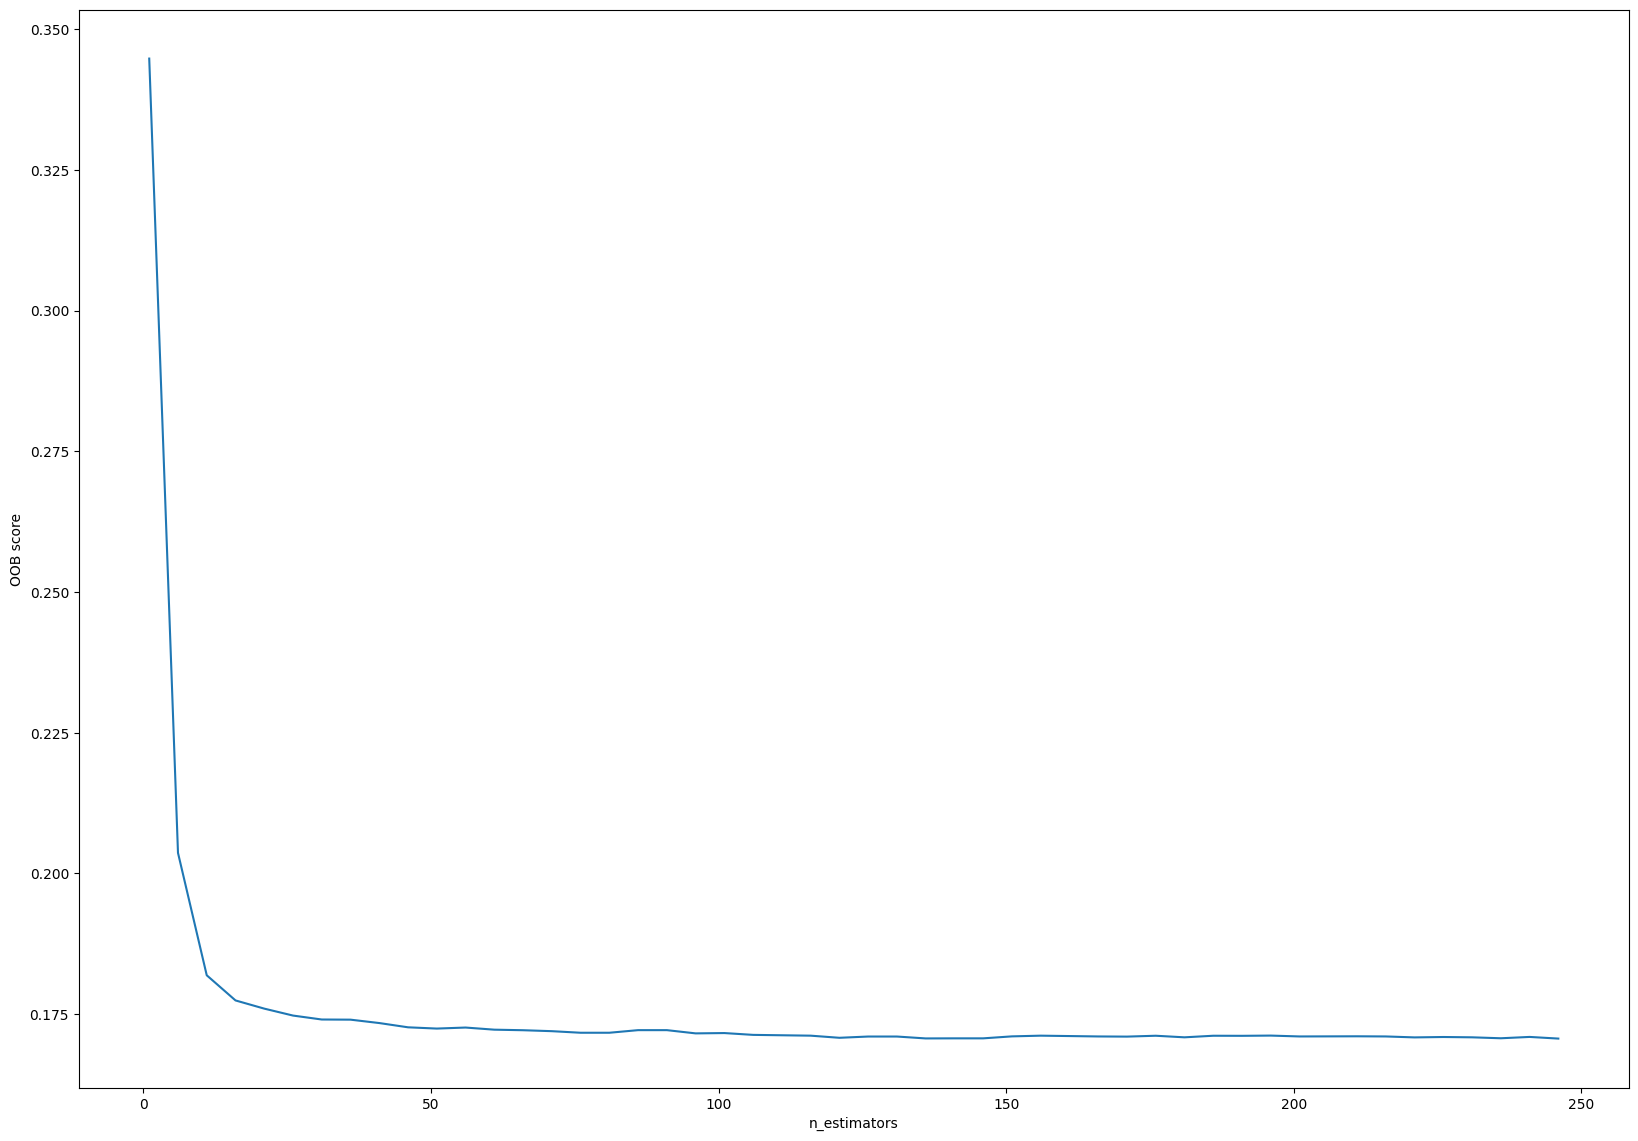

In [66]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

**Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## **Возвращение к задаче**

### **Задание 32. (0.6 баллa)**

- Отобразите`feature_importances_` вашего лучшего случайного леса
- Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму


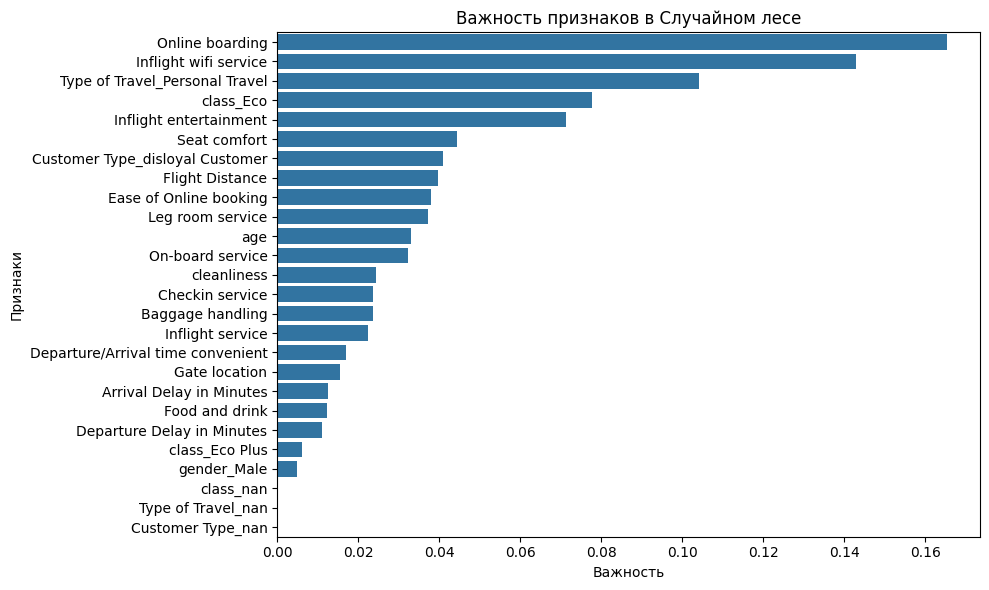

In [67]:
feature_importances = rf_base.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Важность признаков в Случайном лесе')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.tight_layout()
plt.show()

```
Топ-3 признака для дерева решений и случайного леса совпадают, далее идут разные признаки.
```

### **Задание 33. (0.1 баллa)**

- Случайный лес, дающий лучший скор, [сохраните в pickle](https://scikit-learn.ru/stable/model_persistence.html)

In [68]:
# with open('RF.pkl', 'wb') as f:
#  pickle.dump(rf_base, f)

### **Задание 34. (0.25 балла)**
- Интерпретируйте важности признаков с помощью SHAP.
- Опишите полученый график

**Важно:** Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

**Вам может помочь:** [Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [69]:
# X_train_sample = X_train.sample(n=1000, random_state=42)

# explainer = shap.TreeExplainer(rf_base)
# shap_values = explainer.shap_values(X_train_sample)

# shap.summary_plot(shap_values[1], X_train_sample)

`Не дождалась :(`

### **Бонус (0.1 балл)**

- Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется?

```
- KernelExplainer: универсальный объяснитель, который может работать с любыми моделями, включая нейронные сети, даже если они не поддерживают
встроенные методы объяснения.
- Interaction values: SHAP поддерживает вычисление значений взаимодействий между признаками, что помогает выявить зависимости между ними.
- SHAP Explainers: существуют различные объяснители для разных типов моделей, включая деревья решений, градиентный бустинг и линейные модели.
```

### **Бонус (0.5 балла)**

- Интерпретируйте важности признаков для одного прогноза с помощью LIME;
- Опишите полученный график для выбранного наблюдения

`-`

## Котобонус!

0.25 балла

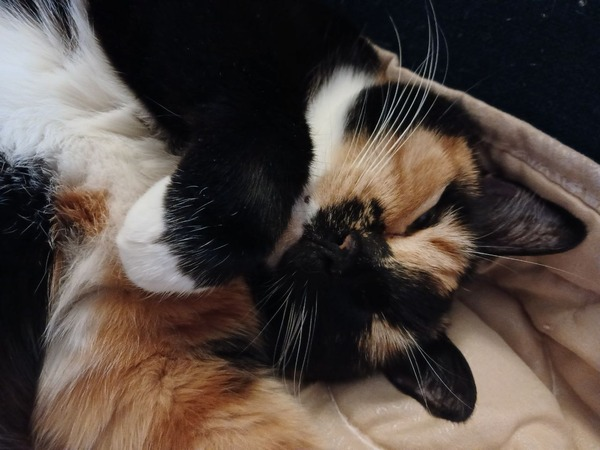

```
Кот Елены :)
```